In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift, fft2, ifft2
from sklearn.cluster import KMeans
from skimage import exposure
import torch
import cv2

In [5]:
# Import images from .npz files
# Extract data file paths
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_sept_data/npz_field_sweep/"

# TEMP SWEEP MOVIES
# movies = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']

# FIELD SWEEP MOVIES OLD
#movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']

#SEPT DATA
# negative [0-12]
movies = ['neg23mT_553_50mW.npz', 'neg23mT_558_25mW.npz', 'neg25mT_553_50mW.npz', 'neg25mT_558_25mW.npz', 'neg27mT_553_50mW.npz',
          'neg27mT_558_25mW.npz', 'neg29mT_553_50mW.npz', 'neg29mT_558_25mW.npz', 'neg31mT_553_50mW.npz', 'neg31mT_558_25mW.npz',
          'neg33mT_553_50mW.npz', 'neg33mT_558_25mW.npz', 'neg35mT_553_50mW.npz',
# positive [13-24]
          'pos23mT_553_50mW.npz', 'pos23mT_558_25mW.npz', 'pos25mT_553_50mW.npz', 'pos25mT_558_25mW.npz', 'pos27mT_553_50mW.npz',
          'pos27mT_558_25mW.npz', 'pos29mT_553_50mW.npz', 'pos29mT_558_25mW.npz', 'pos31mT_553_50mW.npz', 'pos31mT_558_25mW.npz',
          'pos33mT_553_50mW.npz', 'pos33mT_558_25mW.npz']

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
#movies = ['pos29mT_558_50mW.npz']
gif = movies[24]
print(gif)

movie = np.load(file_path + gif)
intensity_data = movie['data']
# Parameters:
#   iterations: Number of iterations to run the diffusion process.
#   kappa: Threshold for edge stopping (higher means less edge detection).
#   gamma: Step size (controls diffusion speed).
niter=50
kappa=30
gamma=.1
# intensity_data = torch.tensor(anisotropic_diffusion(intensity_data, niter=niter, kappa=kappa, gamma=gamma))
print('Tensor shape should be (X,128,128), where X is the number of images.')
print(intensity_data.shape)


pos33mT_558_25mW.npz
Tensor shape should be (X,128,128), where X is the number of images.
(113, 128, 128)


In [6]:
# Global parameters

# Extract data_theta, doesn't matter what image is extracted since we're just getting theta
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
# DATA = np.load('/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/image_111001.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))
resolution = 10.8 #degrees
offset1 = torch.tensor(0., requires_grad=True)
offset2 = torch.tensor(0., requires_grad=True)
end_frame = len(intensity_data)
print(end_frame)
# for the model
MAX_ITER_OFFSET = 101
LR = 1e-2
OFFSET_ADJUSTMENT = 60

113


In [4]:
def mask_images(image, inner_radius=17, outer_radius=30, center_x=64, center_y=62):
    '''Masks signal inside inner_radius and outside outer_radius around the specified center.'''
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    radius = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    mask = (radius > inner_radius) & (radius < outer_radius)
    masked_image = np.copy(image)
    masked_image[~mask] = 0  
    return masked_image

In [5]:
### KMeans clustering

def fourier_hexagonal_clustering(image, n_clusters=2, outer_radius_filter=19, inner_radius_filter=3):
    """
    Extracts hexagonal patterns from a noisy image by filtering in Fourier space 
    and applying clustering to the filtered spatial domain image.
    
    Parameters:
    - image: 2D numpy array, the image to analyze.
    - n_clusters: int, the number of clusters to separate the hexagonal patterns.
    
    Returns:
    - clustered_image: Display of clustered regions in the filtered image.
    """
    
    # Step 1: Fourier Transform
    f_transform = fftshift(fft2(image))
    magnitude_spectrum = np.log(np.abs(f_transform) + 1)

    # Step 2: Apply a Circular Bandpass Filter to Enhance Hexagonal Patterns
    # Define center and radius range for bandpass (tweak based on image)
    center = np.array(f_transform.shape) // 2
    y, x = np.ogrid[:f_transform.shape[0], :f_transform.shape[1]]
    mask = ((x - center[1])**2 + (y - center[0])**2 <= outer_radius_filter**2) & \
           ((x - center[1])**2 + (y - center[0])**2 >= inner_radius_filter**2)
    
    # Apply mask to zero out other frequencies
    f_transform_filtered = f_transform * mask
    image_filtered = np.abs(ifft2(fftshift(f_transform_filtered)))
    filtered_image = mask_images(image_filtered)
    # plt.imshow(filtered_image)
    # plt.show()
    # Step 3: Rescale intensity for clearer clustering results
    filtered_image = exposure.rescale_intensity(filtered_image)
    
    # Step 4: Flatten image and apply K-means clustering to filtered data
    reshaped_data = filtered_image.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(reshaped_data)
    labels = kmeans.labels_.reshape(filtered_image.shape)
    
    # Step 5: Plot the clustered regions in the filtered image
    # plt.figure(figsize=(12, 6))
    # plt.subplot(1, 2, 1)
    # plt.title("intensity")
    # plt.imshow(image)
    
    # plt.subplot(1, 2, 2)
    # plt.title("Clustered Regions in Filtered Image")
    # plt.imshow(labels)
    # plt.axis('off')
    # plt.show()


    return labels

print(intensity_data[0].shape)
labels = fourier_hexagonal_clustering(intensity_data[0])
print(labels.shape)



(128, 128)
(128, 128)


In [6]:
clustered_data = []
for i in range(end_frame):
    cluster = fourier_hexagonal_clustering(intensity_data[i])
    clustered_data.append(cluster)

clustered_data = np.array(clustered_data).astype('uint8')

In [7]:
# CREATION OF K-MEANS FILTERS TO APPLY TO RAW DATA
kmeans_filter = [fourier_hexagonal_clustering(intensity_data[i]) for i in range(end_frame)]
filtered_data = [kmeans_filter[i] * intensity_data[i] for i in range(end_frame)]
filtered_data = np.array(filtered_data).astype('uint8')
print(filtered_data.shape)

(113, 128, 128)


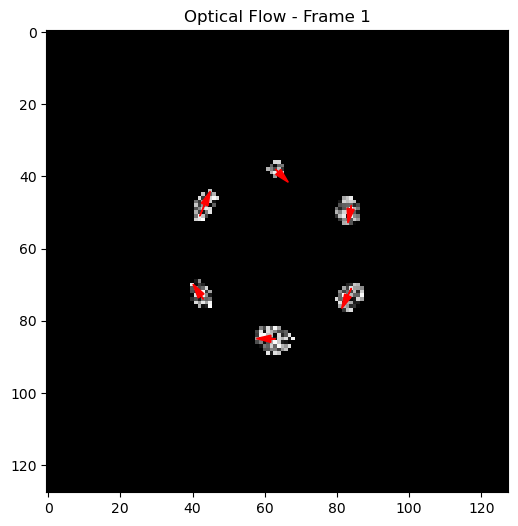

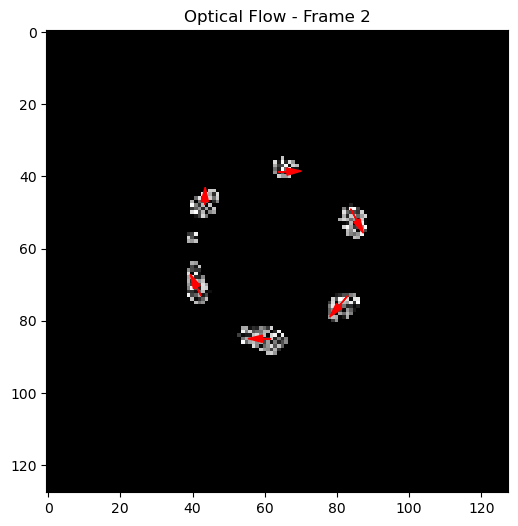

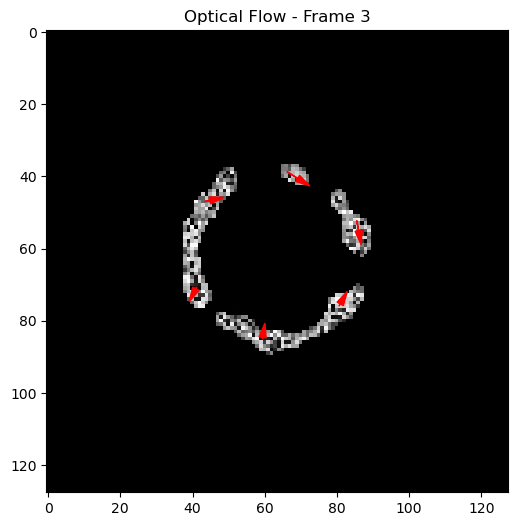

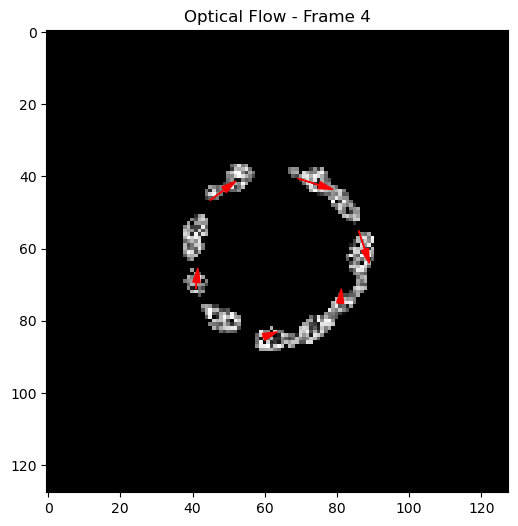

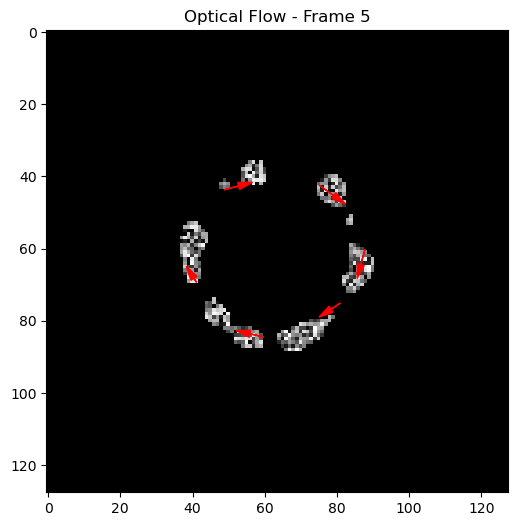

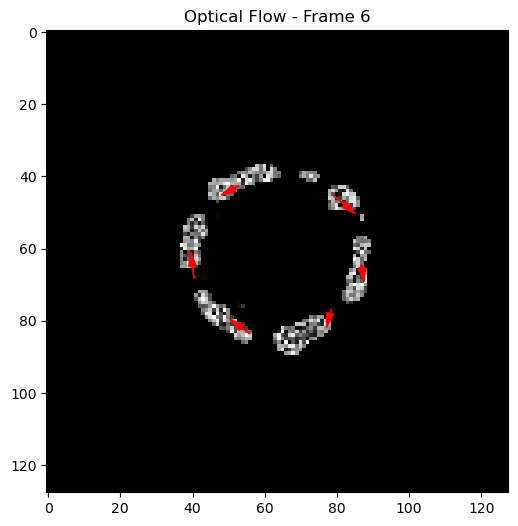

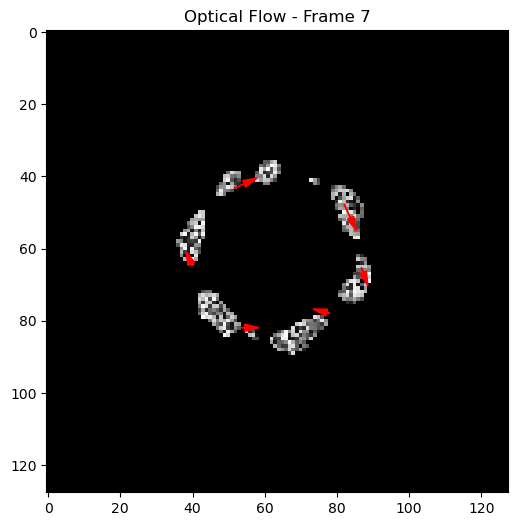

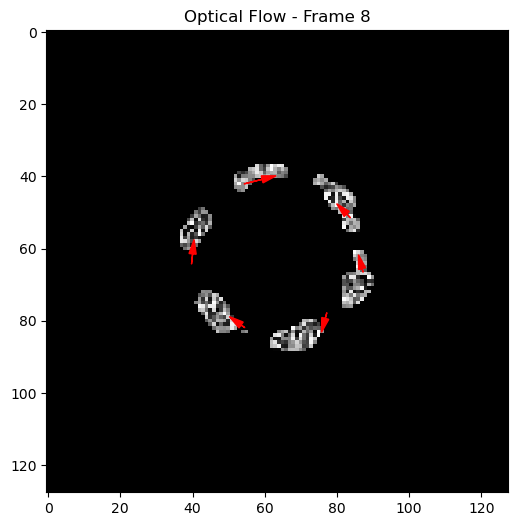

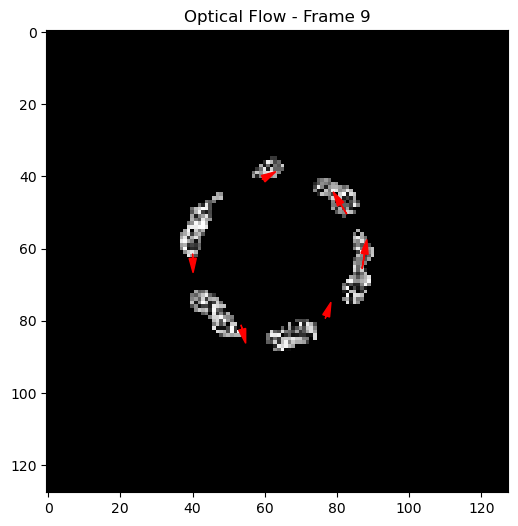

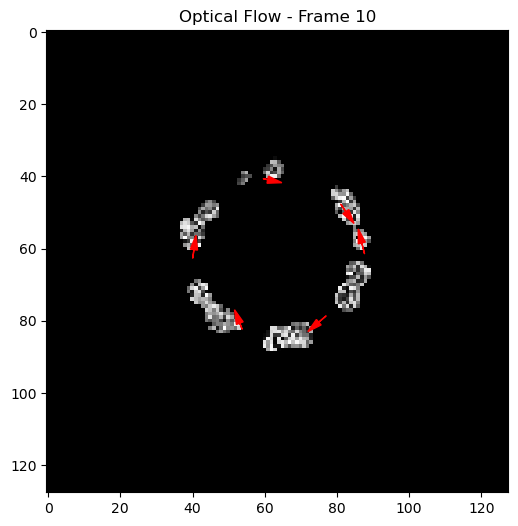

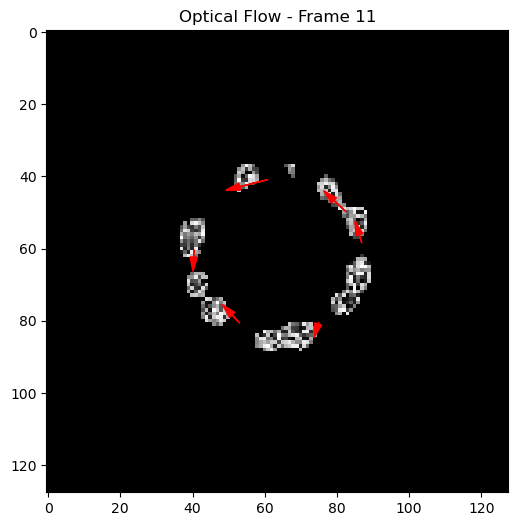

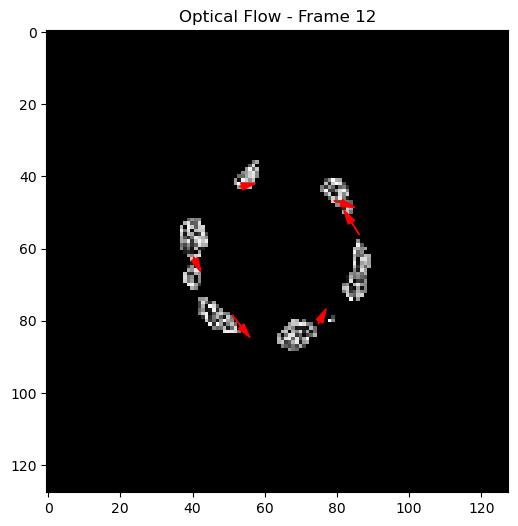

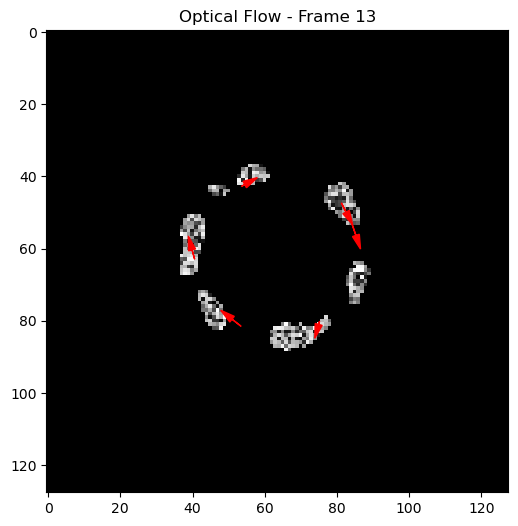

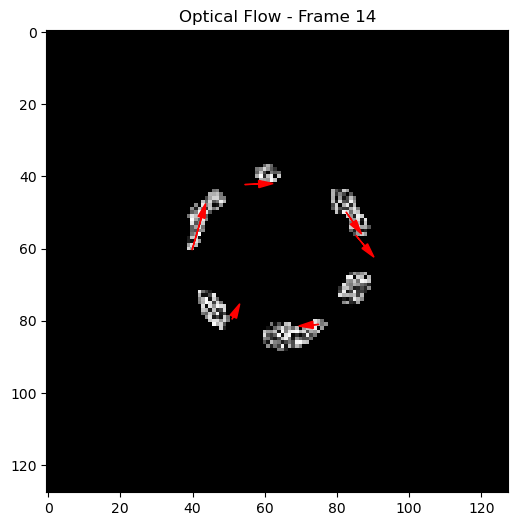

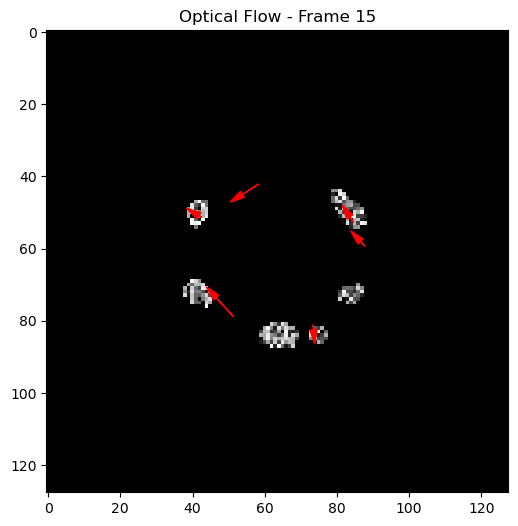

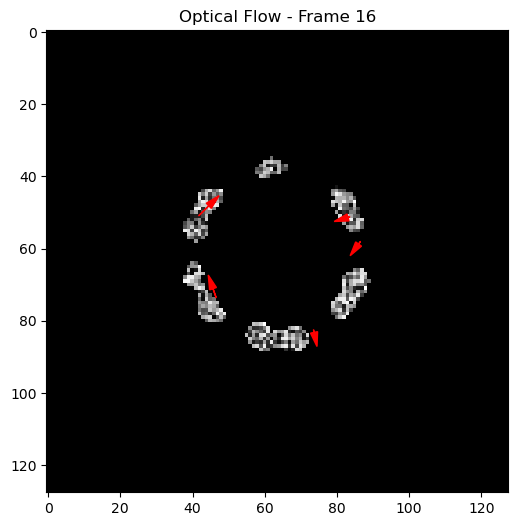

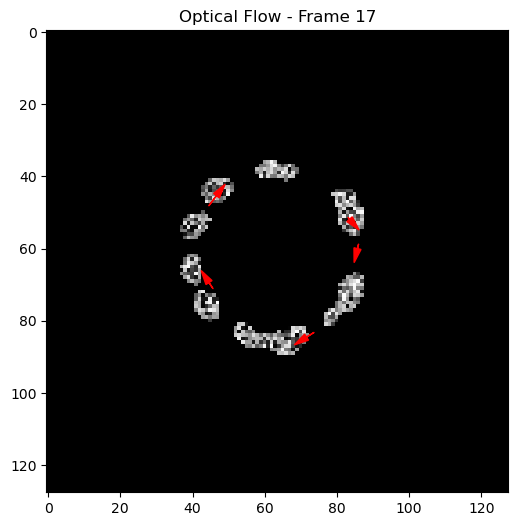

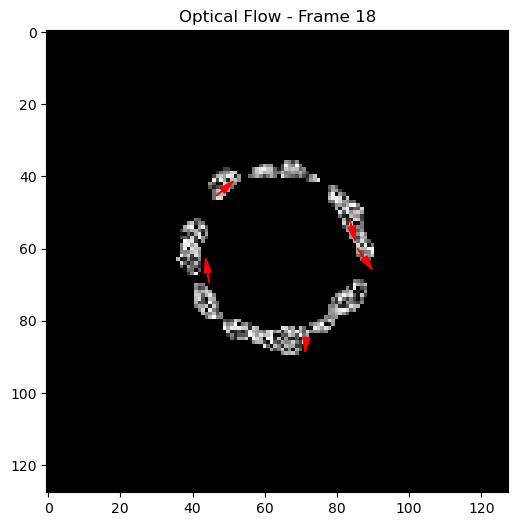

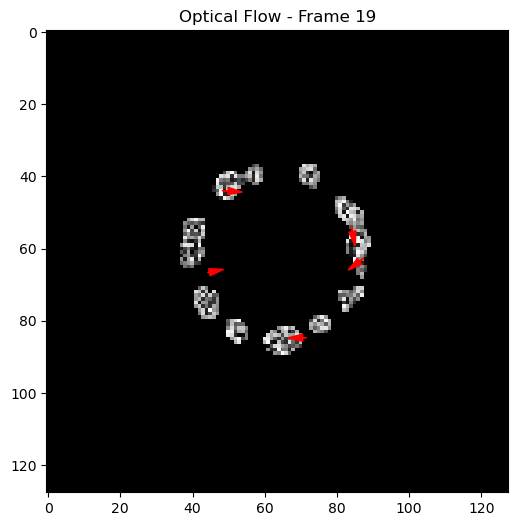

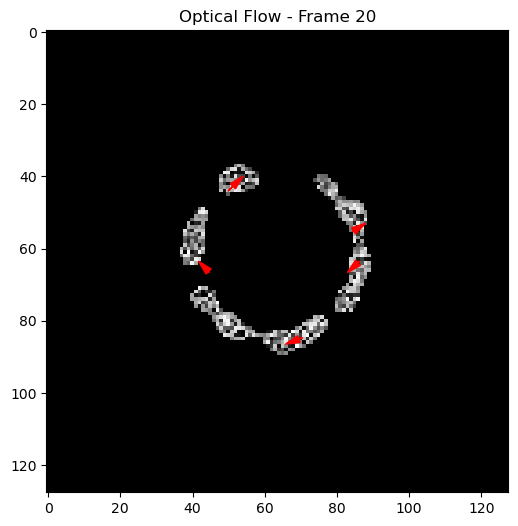

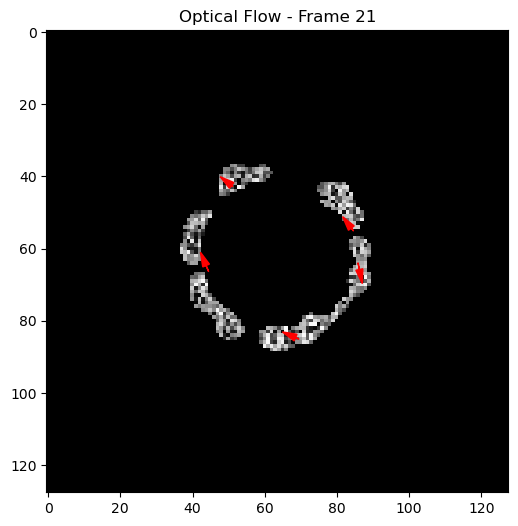

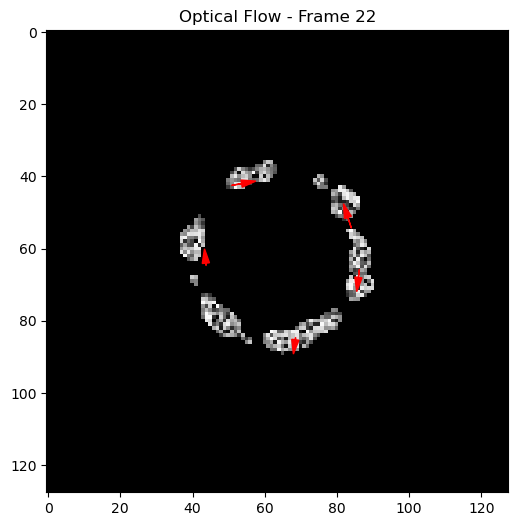

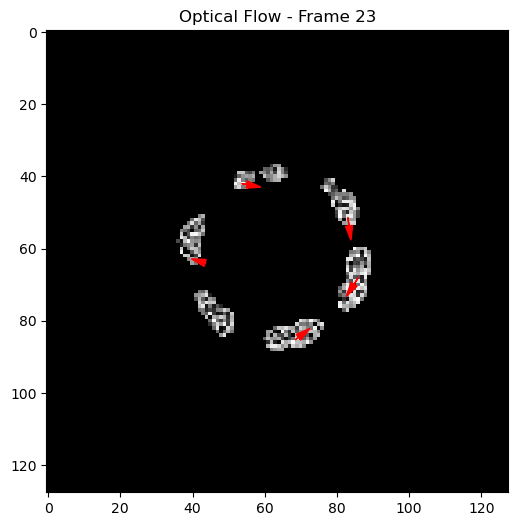

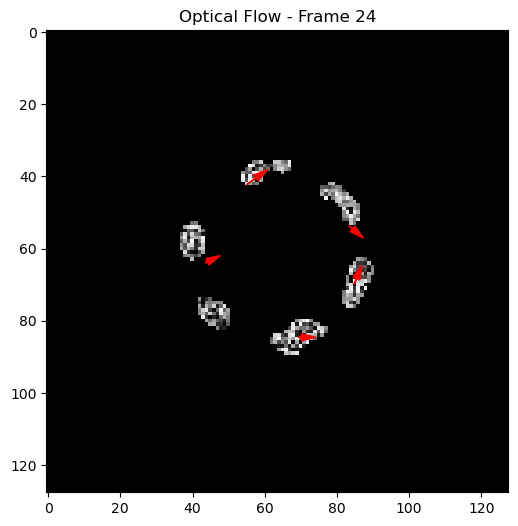

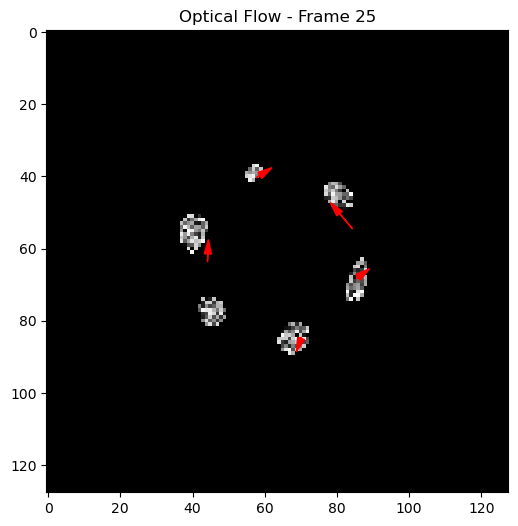

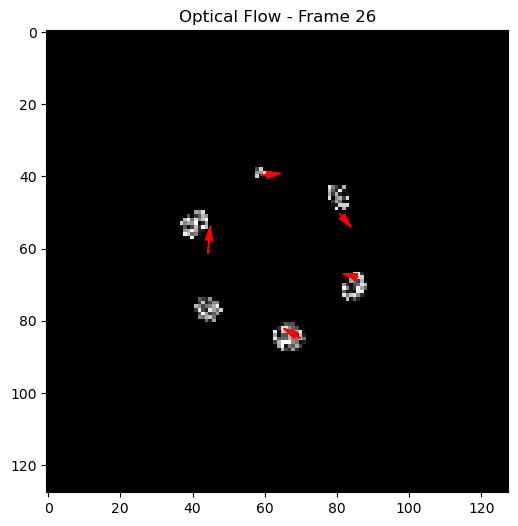

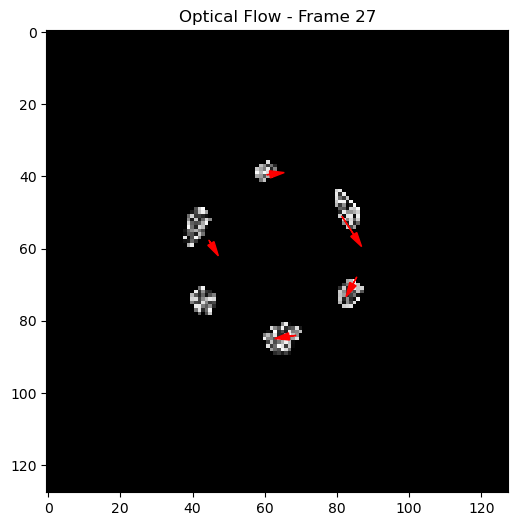

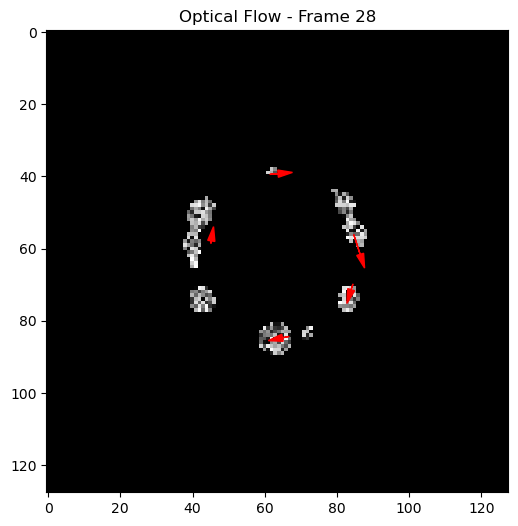

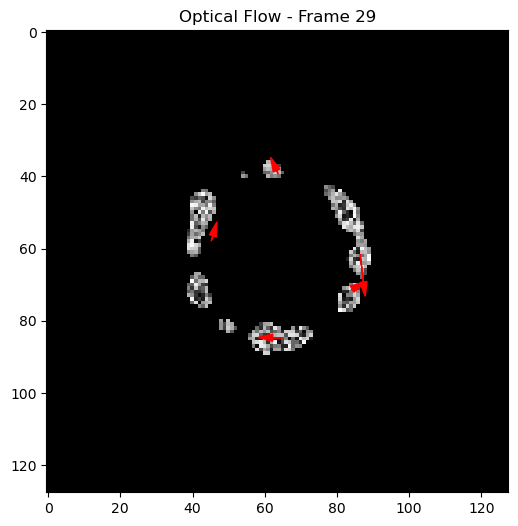

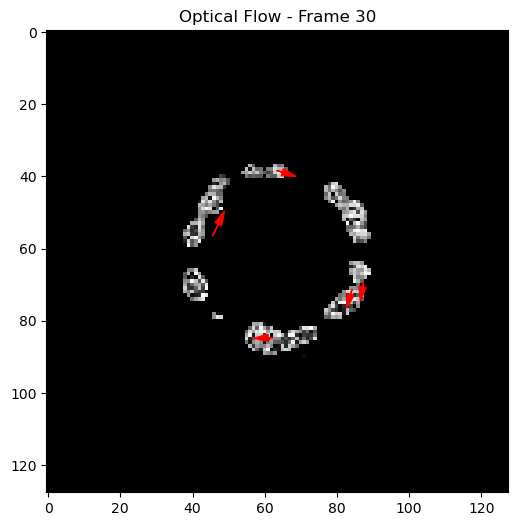

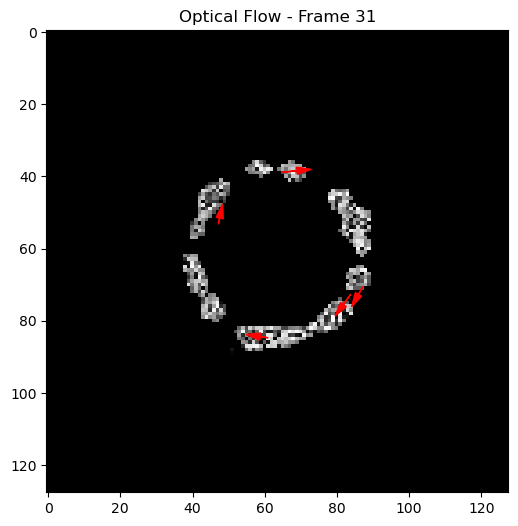

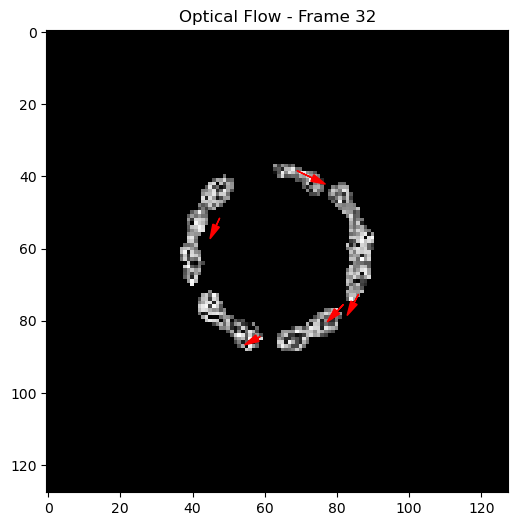

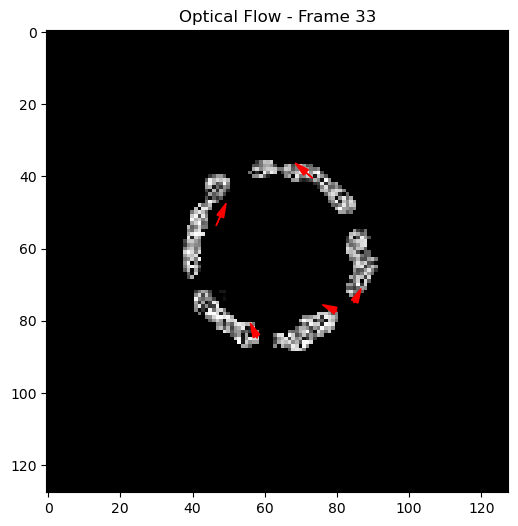

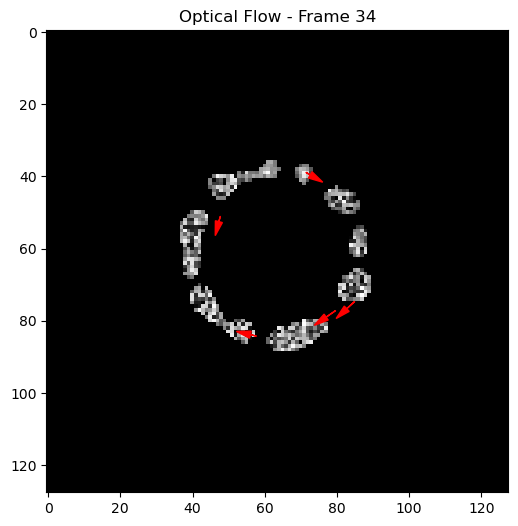

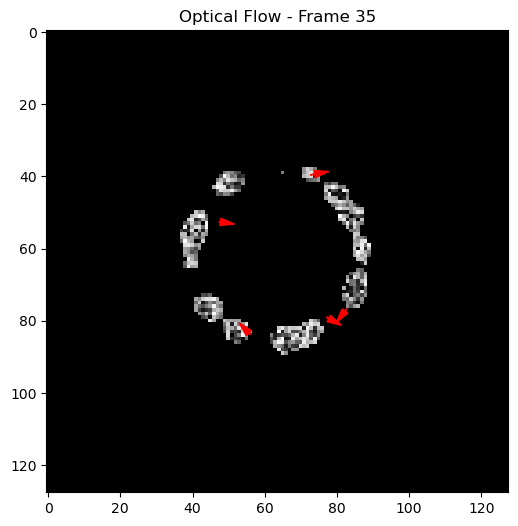

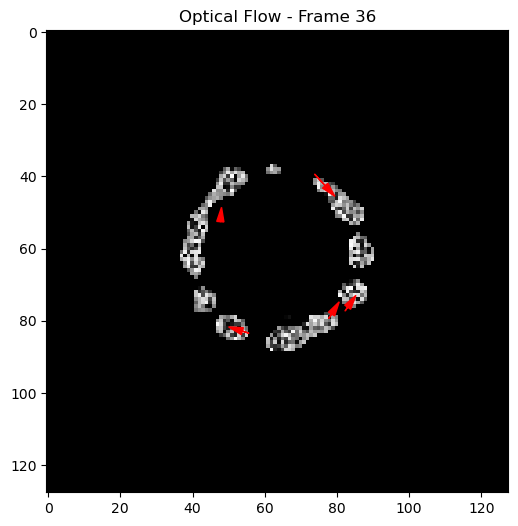

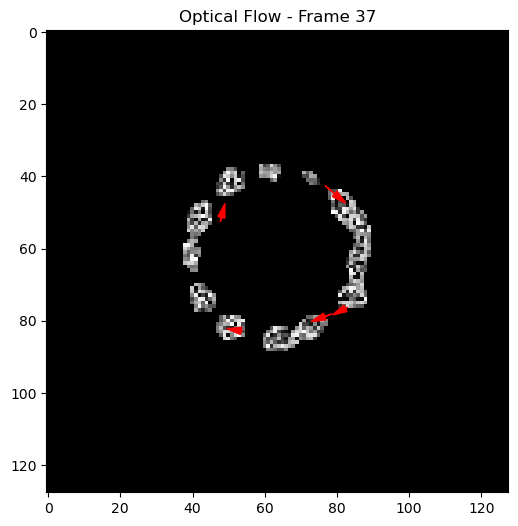

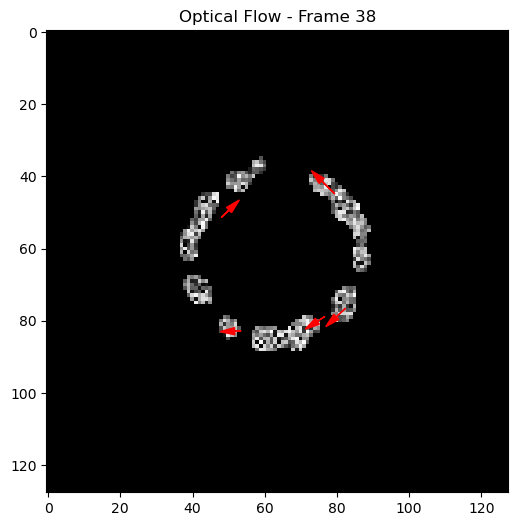

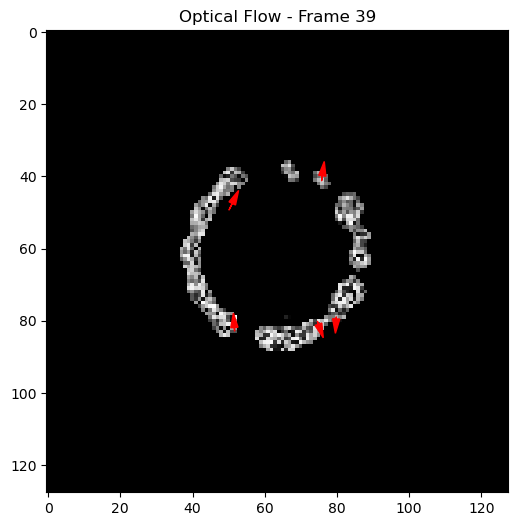

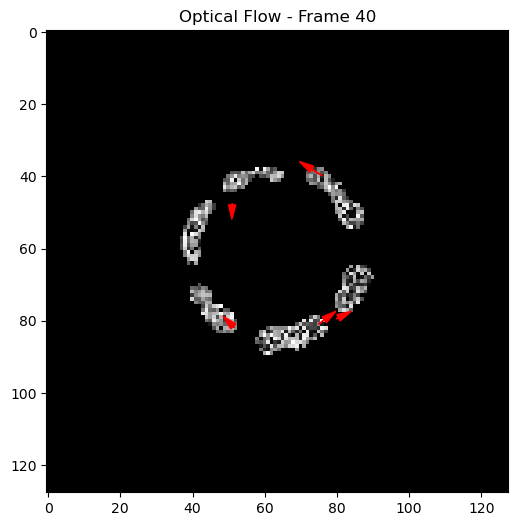

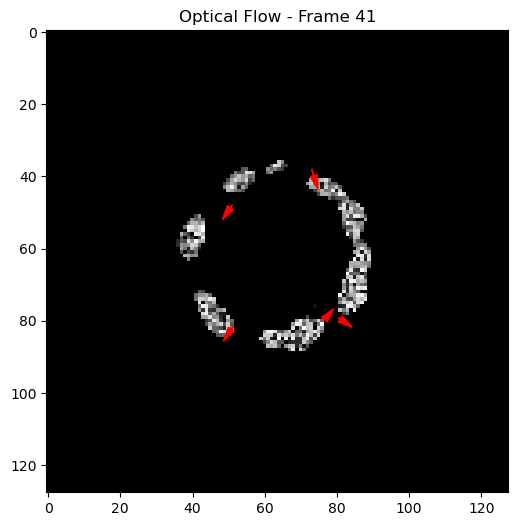

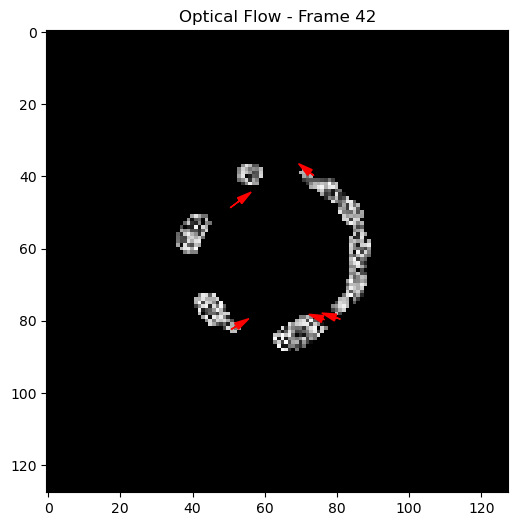

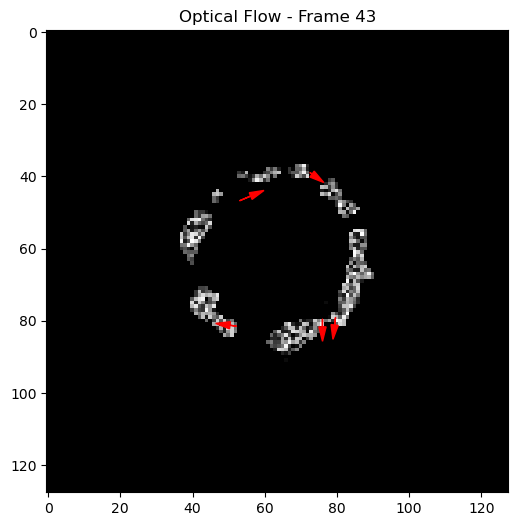

KeyboardInterrupt: 

In [8]:
# SPARSE OPTICAL FLOW
lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

prev_pts = cv2.goodFeaturesToTrack(filtered_data[0], mask=None, **dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7))

for i in range(1, len(filtered_data)):
    # Compute optical flow from previous to current frame
    next_pts, status, err = cv2.calcOpticalFlowPyrLK(filtered_data[i-1], filtered_data[i], prev_pts, None, **lk_params)

    # Select the good points
    good_new = next_pts[status == 1]
    good_old = prev_pts[status == 1]

    # Visualize optical flow
    plt.figure(figsize=(6, 6))
    plt.imshow(filtered_data[i], cmap='gray')
    for new, old in zip(good_new, good_old):
        a, b = new.ravel()
        c, d = old.ravel()
        plt.arrow(c, d, a - c, b - d, color='r', head_width=2, head_length=4)
    plt.title(f"Optical Flow - Frame {i}")
    plt.show()

    # Update previous points for the next frame
    prev_pts = good_new.reshape(-1, 1, 2)

In [ ]:
# DENSE OPTICAL FLOW

step=4
# Loop through the frames to calculate and plot optical flow
for i in range(1, end_frame - 1):
    # Calculate optical flow between consecutive frames
    flow = cv2.calcOpticalFlowFarneback(filtered_data[i - 1], filtered_data[i], None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Get the horizontal and vertical flow components
    flow_x = flow[..., 0]
    flow_y = flow[..., 1]

    # Set up a grid for quiver plot with step size
    x, y = np.meshgrid(np.arange(0, flow.shape[1], step), np.arange(0, flow.shape[0], step))
    u = flow_y[::step, ::step]  # Vertical component
    v = flow_x[::step, ::step]  # Horizontal component

    # Plot the frame with optical flow vectors
    # plt.figure(figsize=(8, 8))
    # plt.imshow(filtered_data[i], cmap='gray')
    # plt.quiver(x, y, v, u, color='red', angles='xy', scale_units='xy', scale=1)
    # plt.title(f'Optical Flow Vectors - Frame {i}')
    # plt.show()


In [8]:
# 2 FILTER GRADIENT DESCENT

def k_val(fwhm):
    '''fwhm is your resolution given in degrees.

    This is derived based off the assumption that FWHM for the cosine 
    is approximately equal to a gaussian, which is a good assumption for this case
    Because FWHM for the cosine filter is approx equal to FWHM for a gaussian'''
    fwhm = np.deg2rad(fwhm)
    k = np.log(1/2) / (np.log(np.cos(3/2*fwhm)**2))
    return k

k = k_val(resolution)
print('k =', k)

n_folds = 6
def filter_function(k, theta, n_folds=n_folds):
    filter = torch.exp(k * torch.log((torch.cos(n_folds / 2 * theta))**2))
    return filter

offset1_init = torch.tensor(0., requires_grad=True)
offset2_init = torch.tensor(0., requires_grad=True)
penalty_strength = 10E6
def gradient_descent_optimize_offset(intensity, offset, offset_second, k=k, penalty_strength=penalty_strength):
    # First Gradient Descent to find the global maximum
    opt = torch.optim.Adam([offset], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta = filter_function(k, DATA_THETA + offset)
        loss = -(torch.tensor(intensity) * evaluate_image_theta).sum()
        opt.zero_grad()
        loss.backward()
        opt.step()

    # Store the first optimal offset
    first_offset = offset.clone().detach()

    # Second Gradient Descent with penalty to avoid first peak
    opt_second = torch.optim.Adam([offset_second], lr=LR)
    for i in range(MAX_ITER_OFFSET):
        evaluate_image_theta_second = filter_function(k, DATA_THETA + offset_second)
        penalty = penalty_strength * filter_function(1/2*k, offset_second - first_offset)

        # Modified loss with penalty
        loss_second = -(torch.tensor(intensity) * evaluate_image_theta_second).sum() + penalty
        opt_second.zero_grad()
        loss_second.backward()
        opt_second.step()

        # set all values greater that .01 to 1 in filter
    filter_to_ones1 = evaluate_image_theta.clone().detach().numpy()
    filter_to_ones2 = evaluate_image_theta_second.clone().detach().numpy()
    threshold = .2
    filter_to_ones1[filter_to_ones1 > threshold] = 1
    filter_to_ones1[filter_to_ones1 <= threshold] = 0
    filter_to_ones2[filter_to_ones2 > threshold] = 1
    filter_to_ones2[filter_to_ones2 <= threshold] = 0

    return first_offset.item(), filter_to_ones1, offset_second.item(), filter_to_ones2

i = 5
offset1, filter1, offset2, filter2 = gradient_descent_optimize_offset(filtered_data[i], offset1_init, offset2_init)
# plt.imshow(filtered_data[i])
# plt.show()
# plt.imshow(filter1)
# plt.show()
# plt.imshow(filter2)
# plt.show()

k = 8.553968178278982


NameError: name 'filtered_data' is not defined

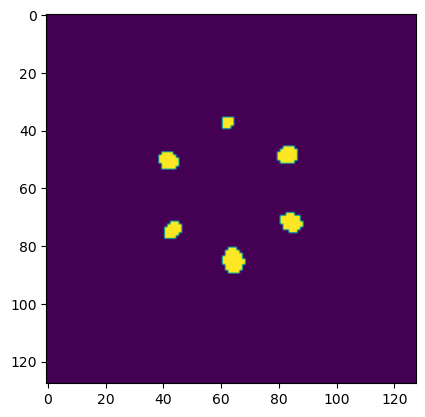

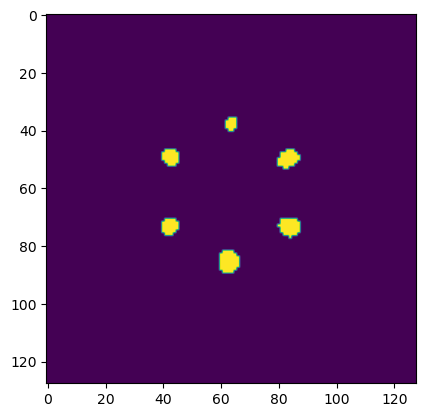

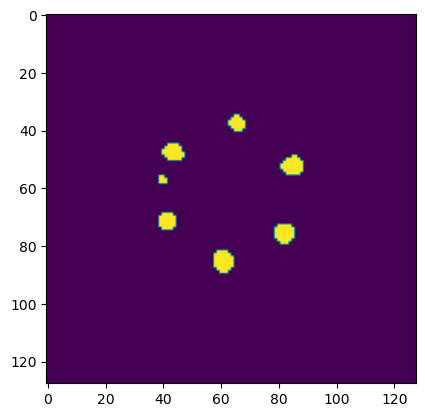

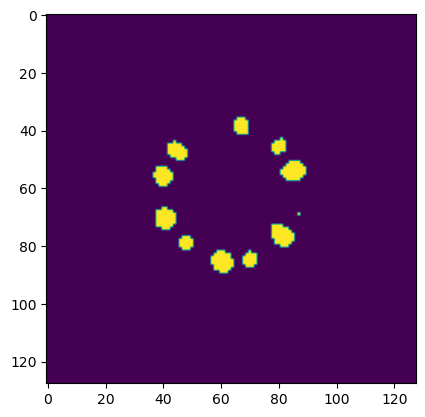

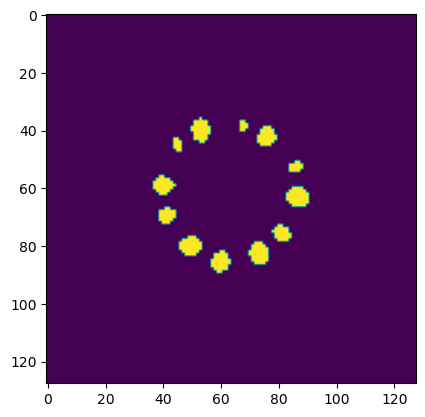

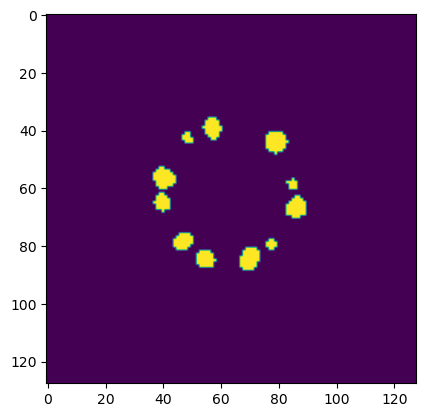

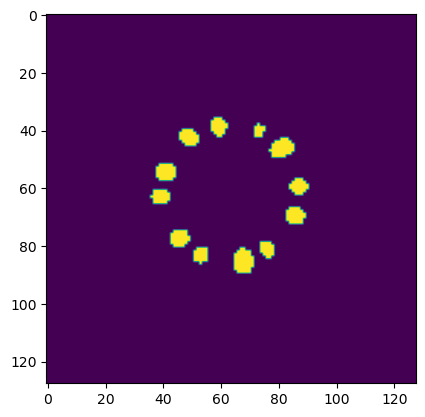

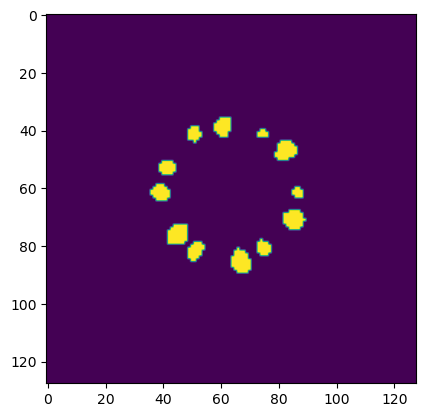

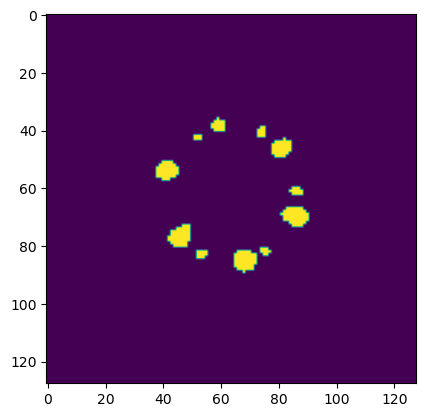

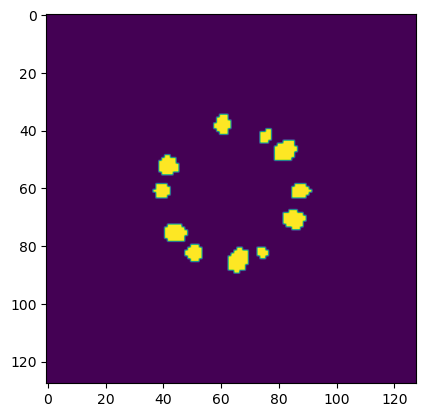

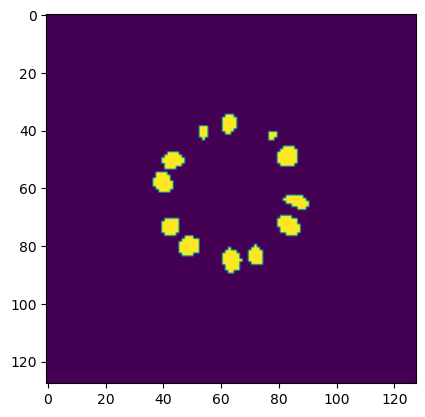

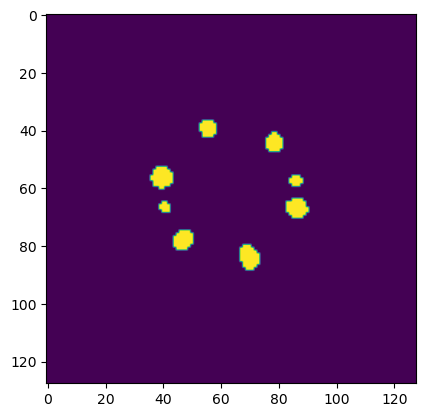

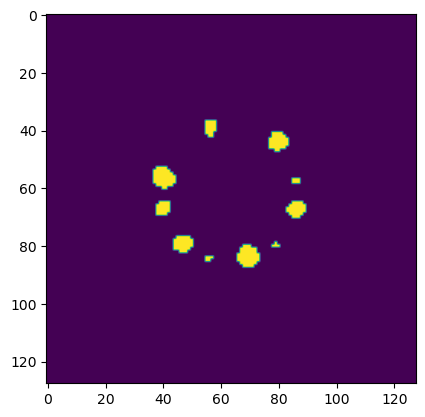

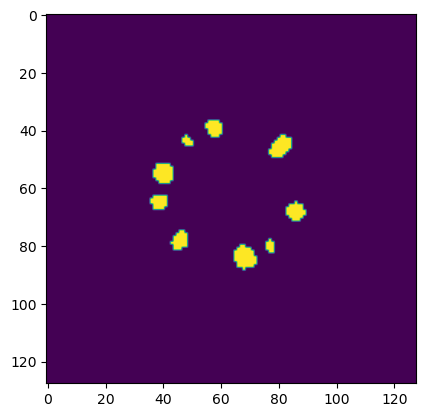

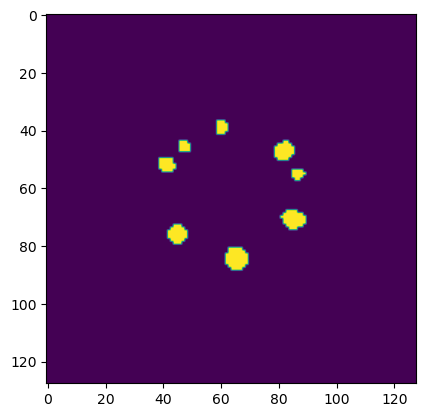

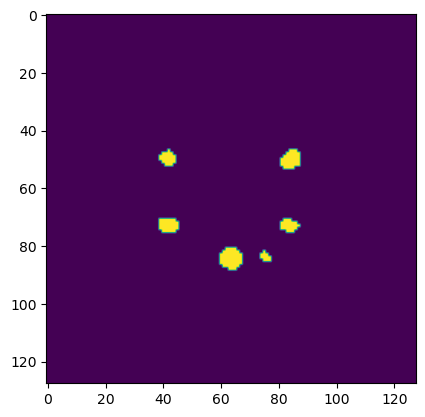

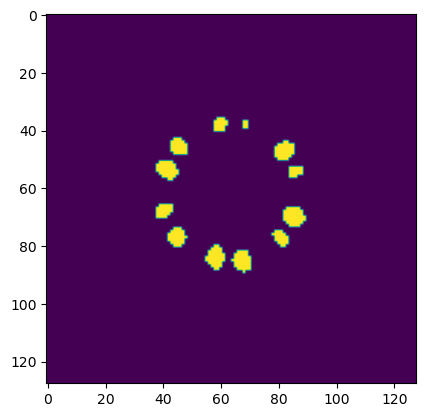

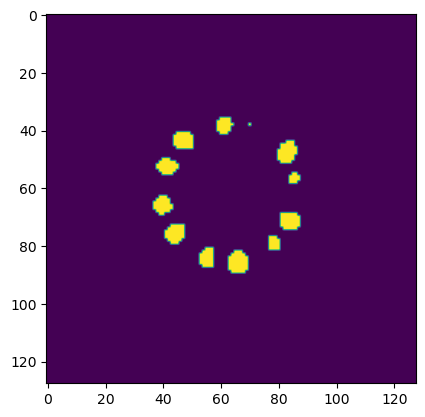

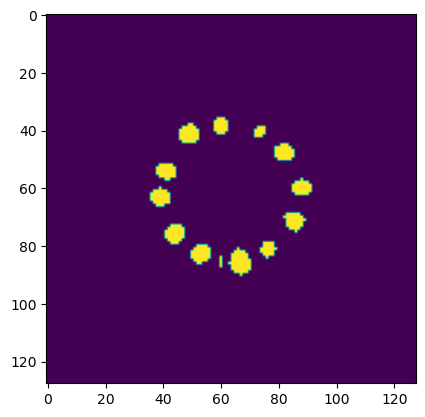

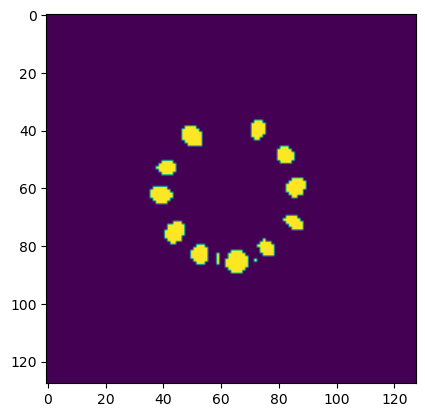

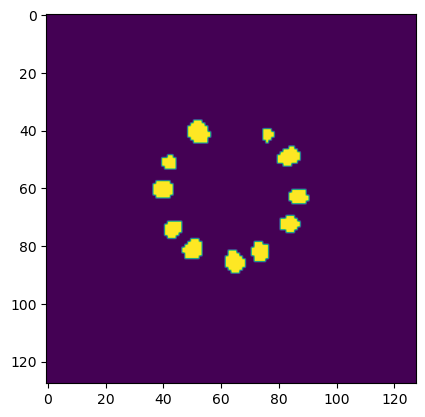

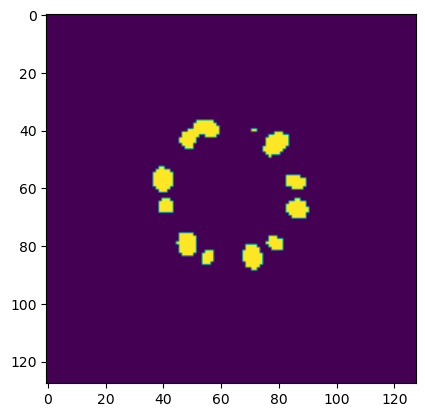

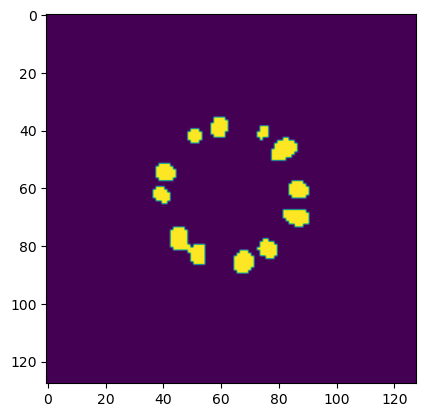

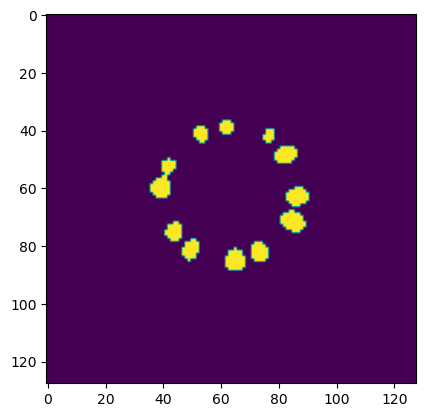

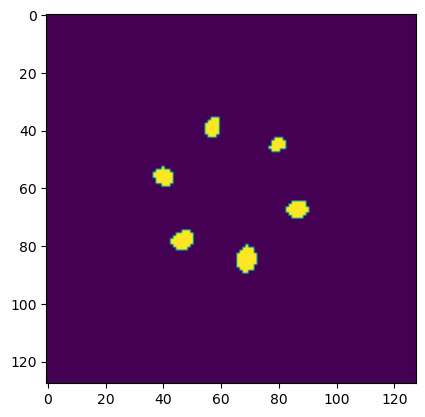

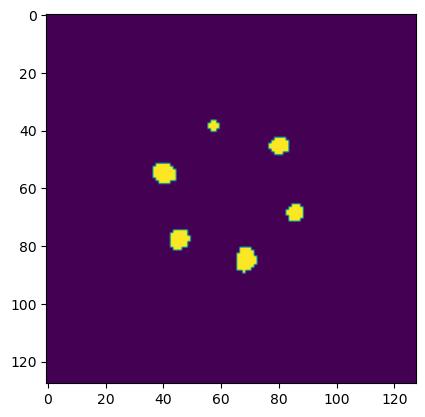

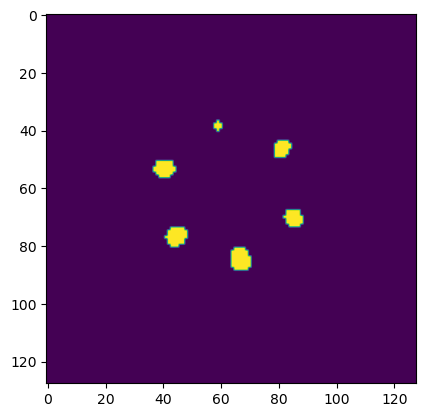

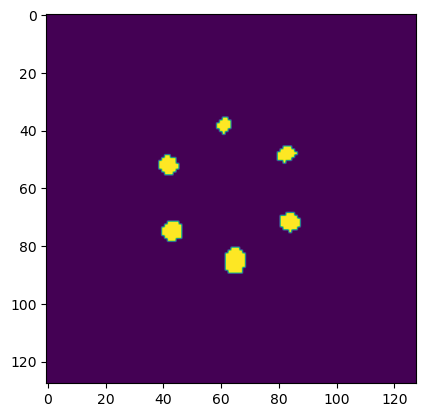

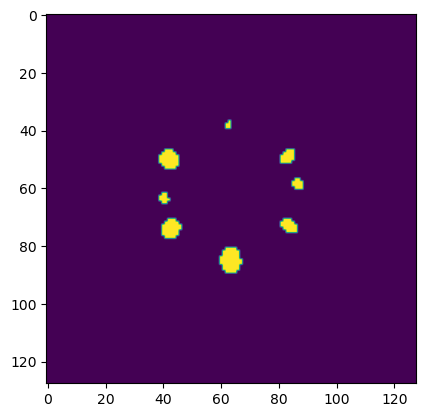

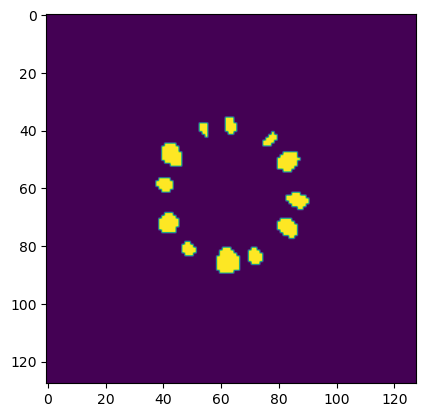

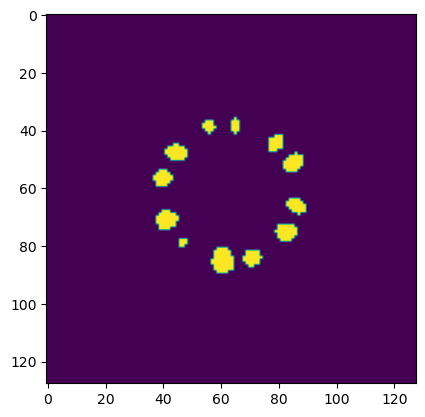

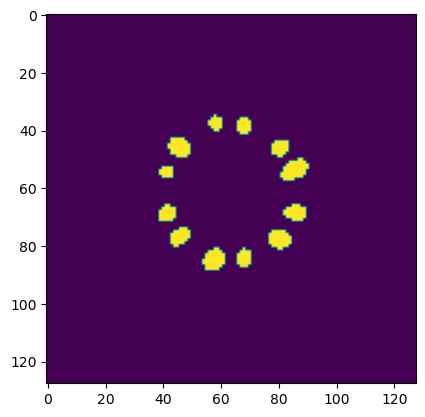

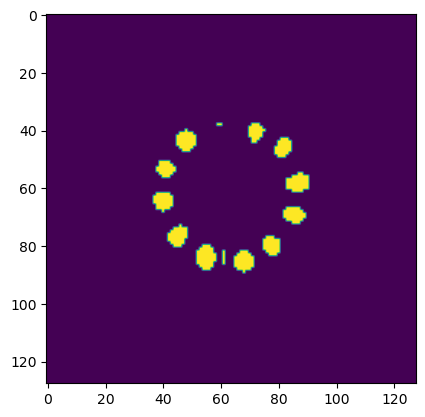

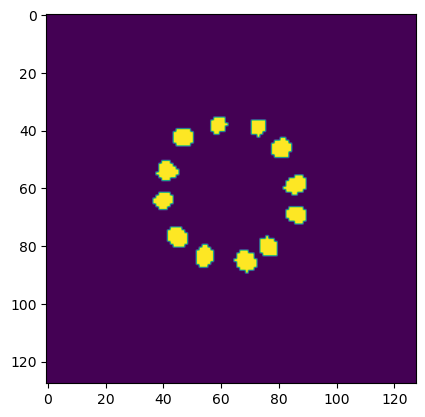

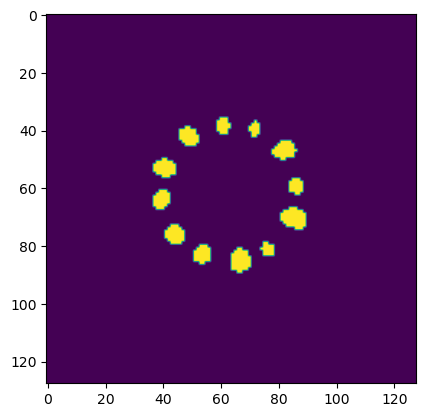

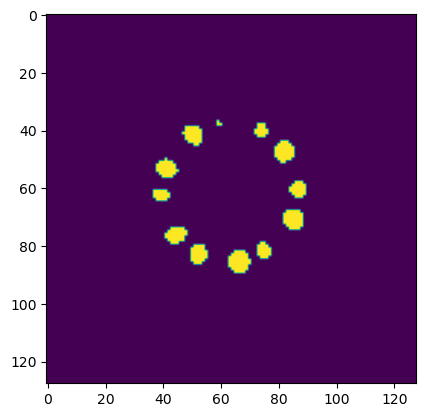

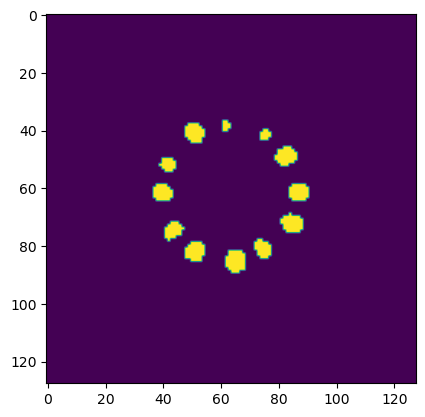

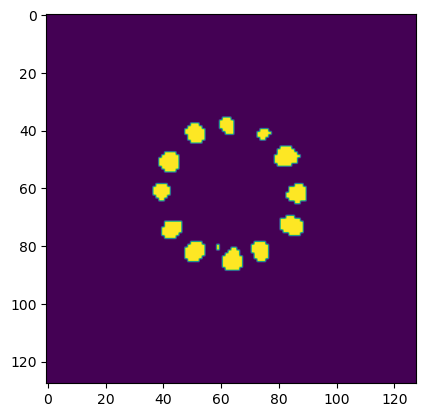

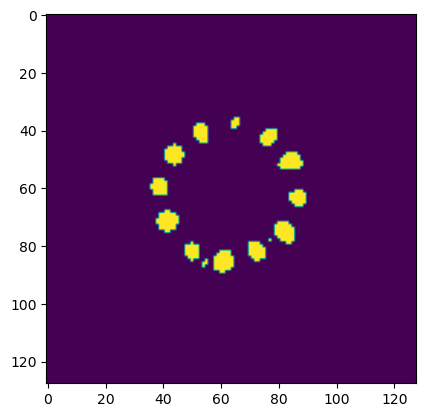

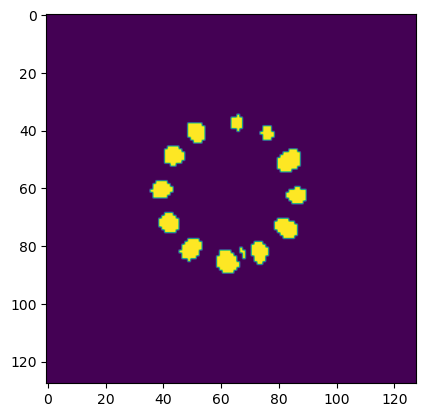

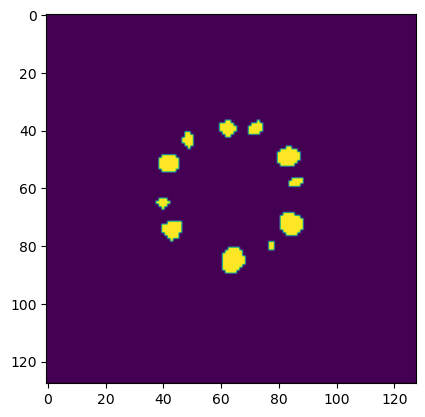

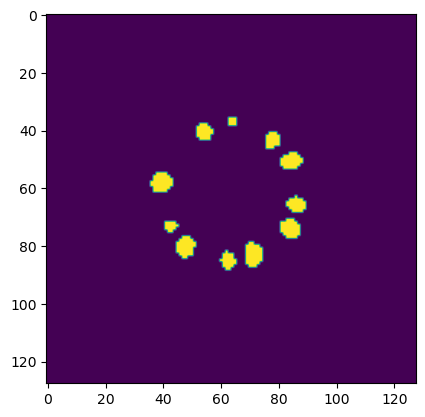

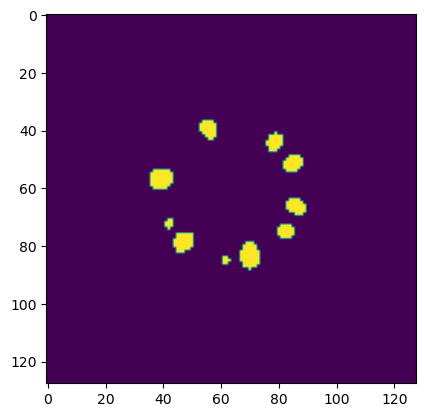

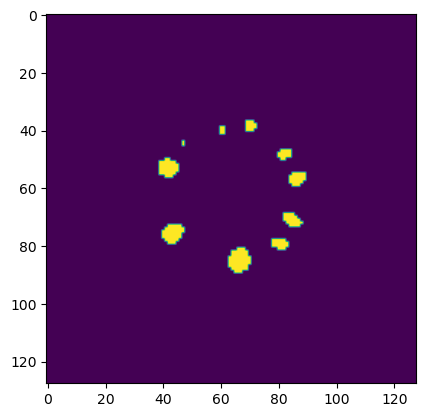

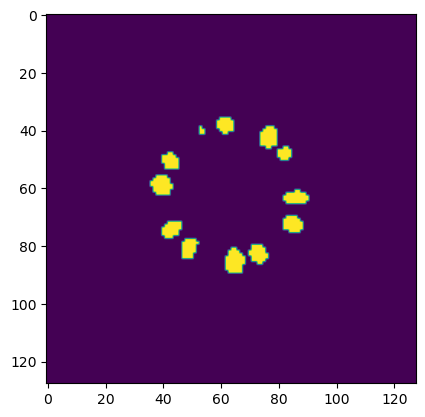

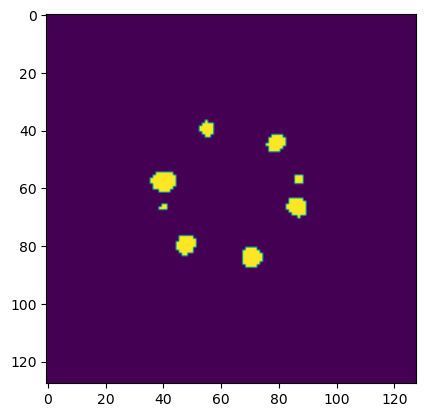

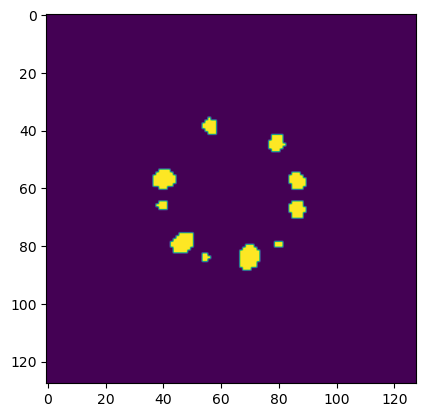

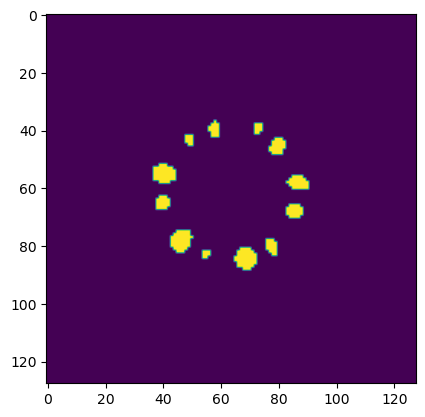

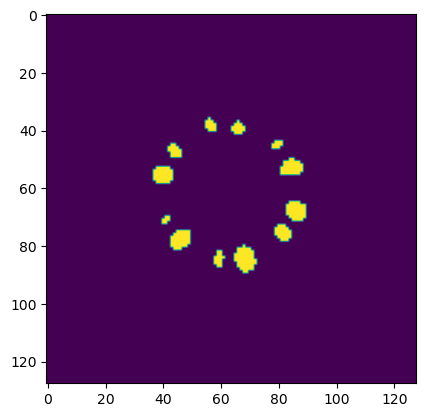

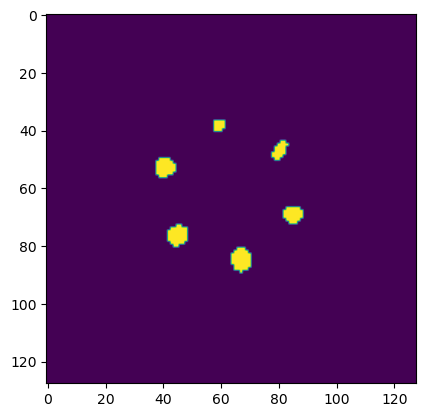

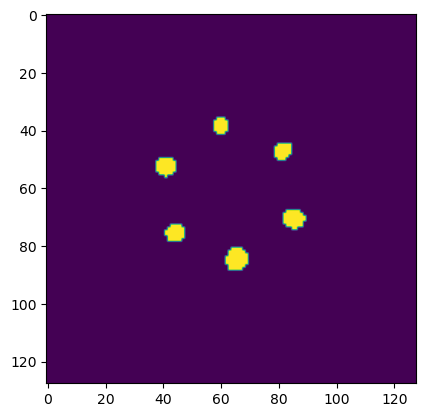

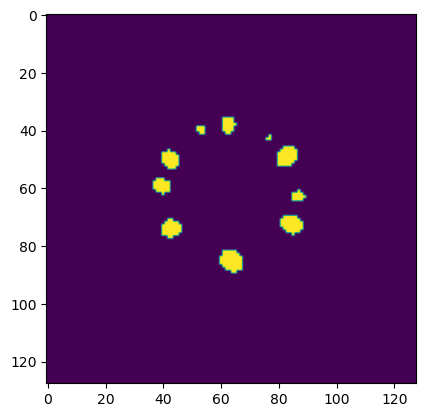

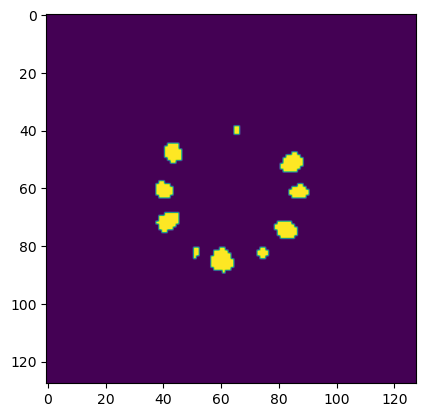

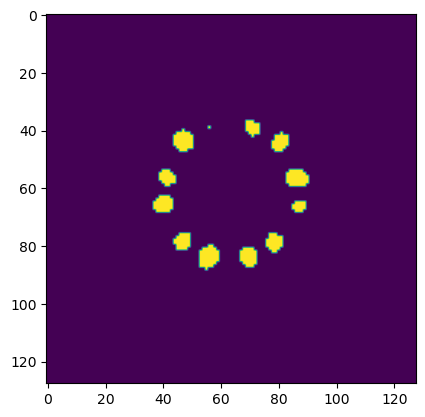

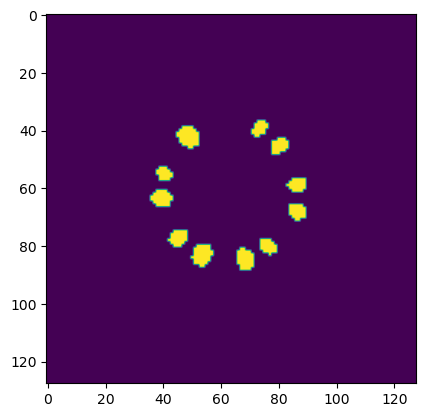

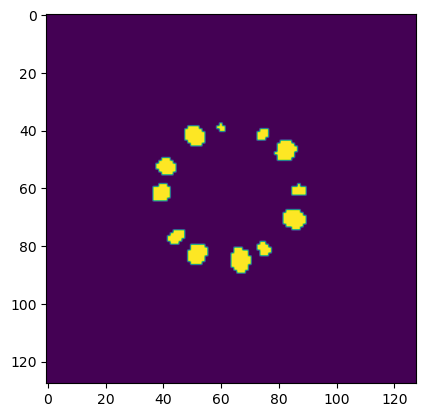

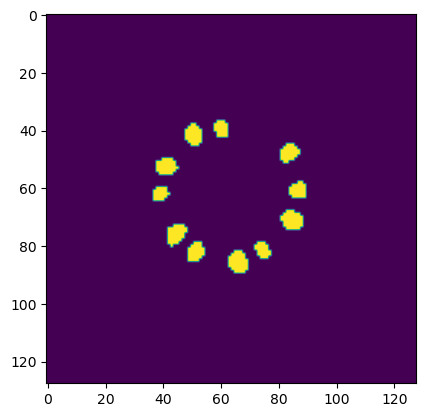

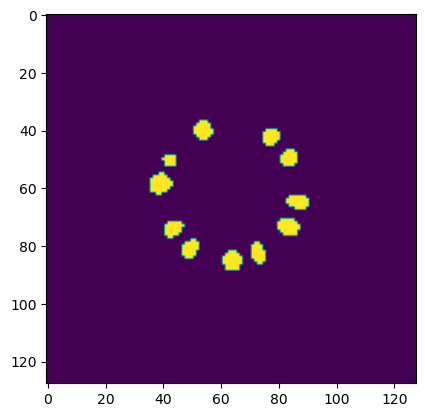

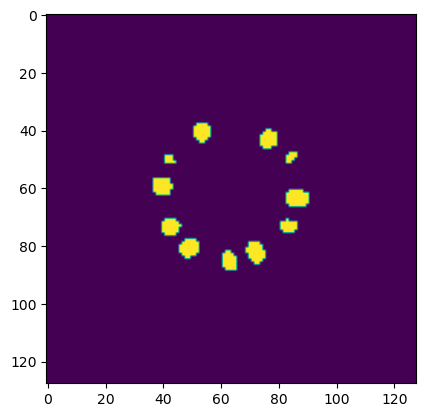

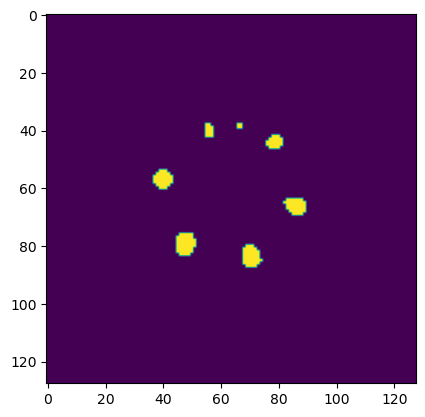

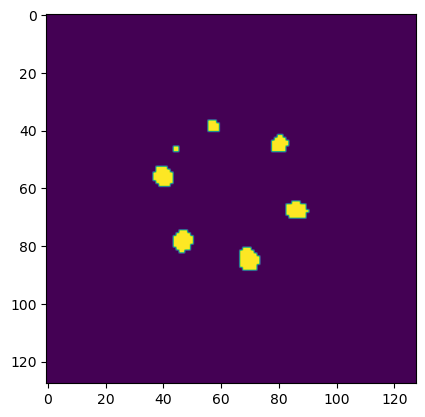

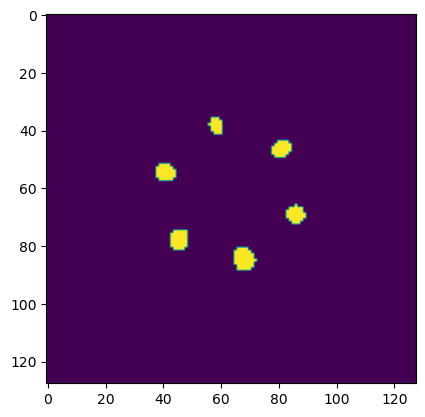

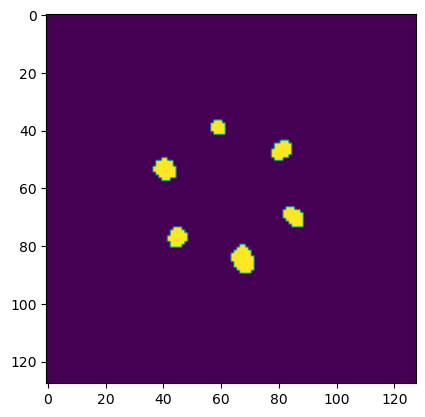

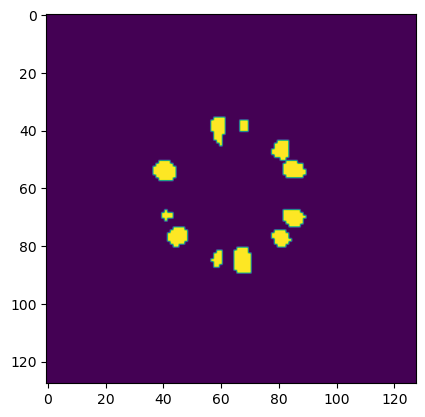

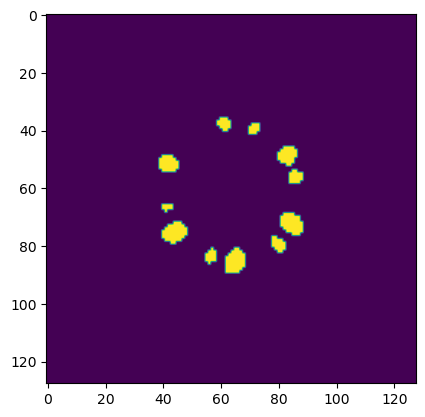

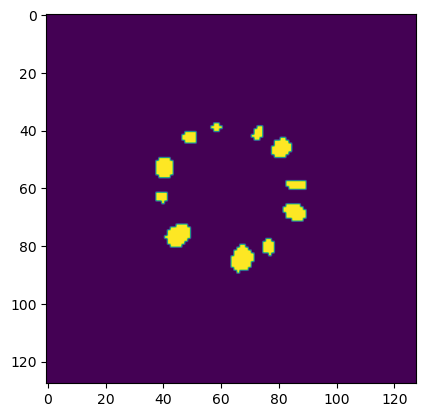

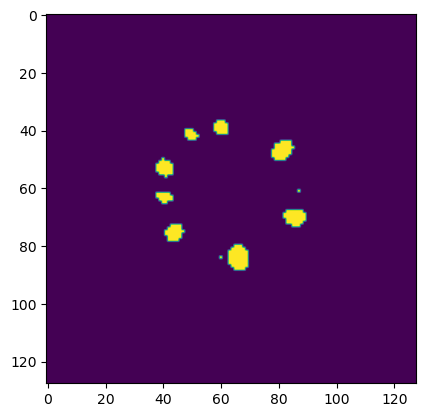

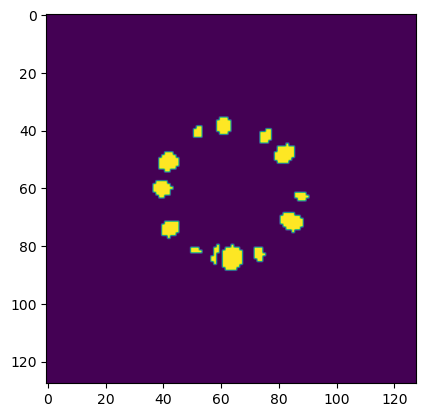

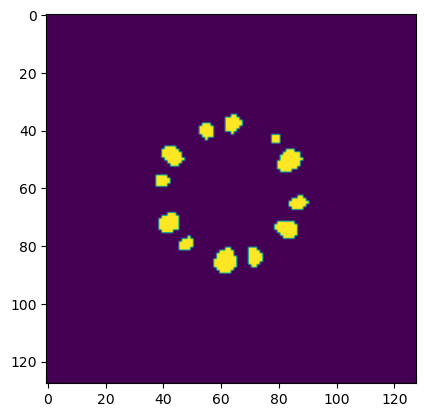

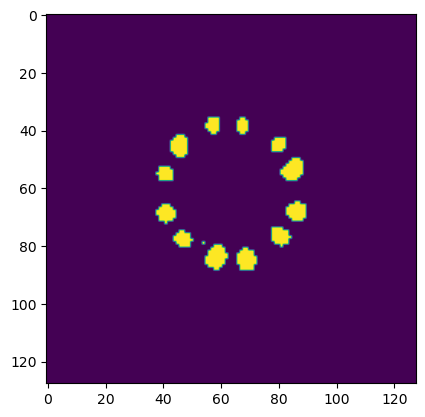

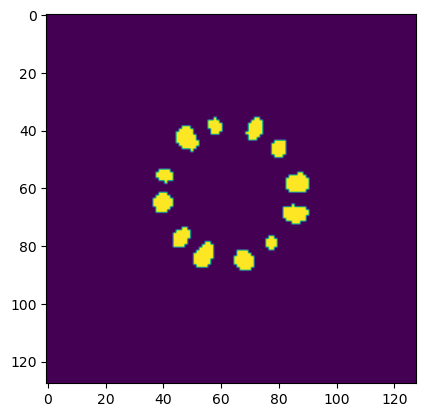

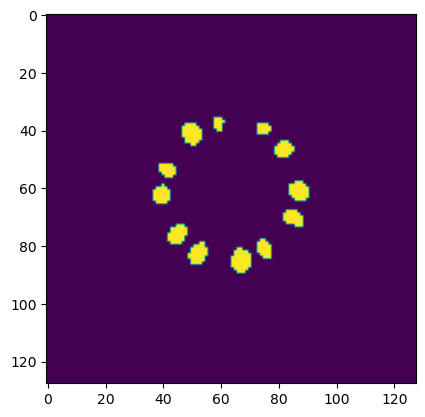

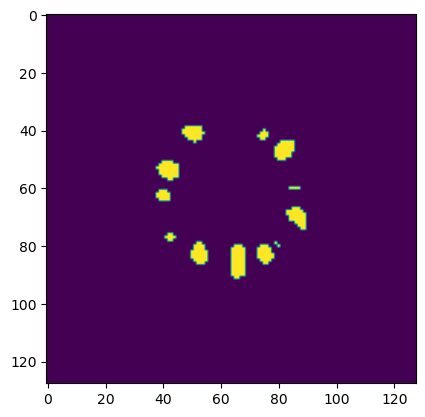

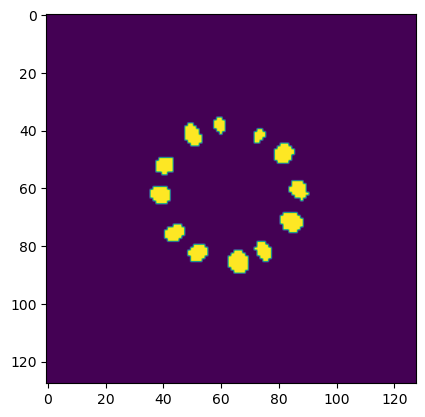

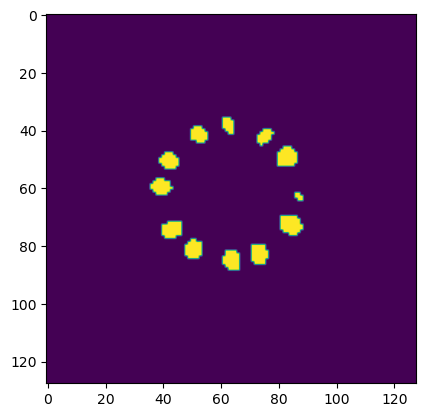

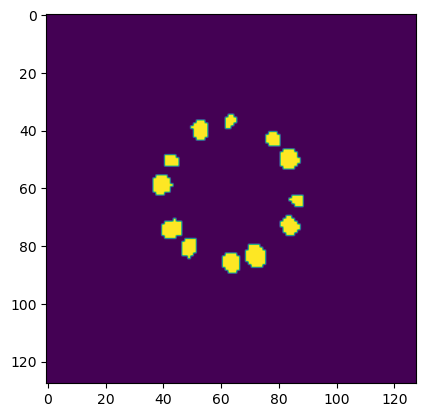

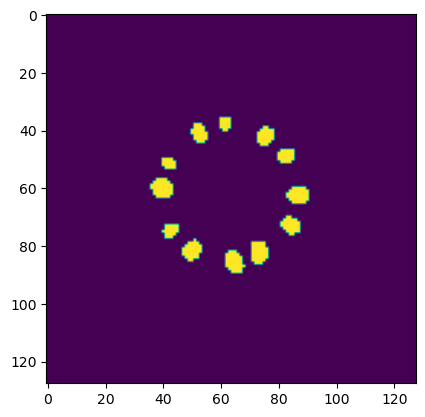

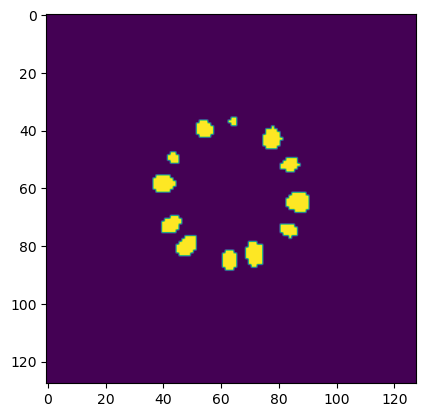

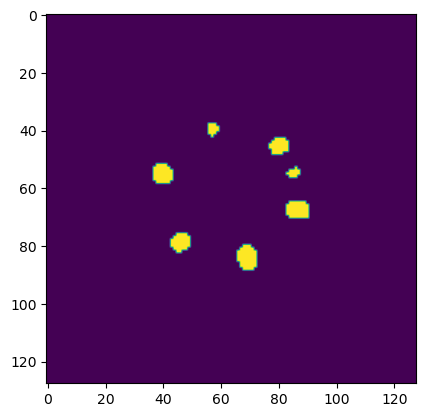

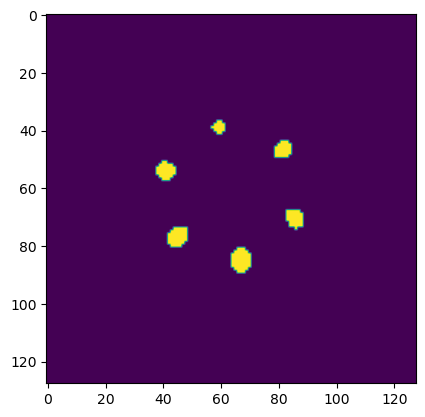

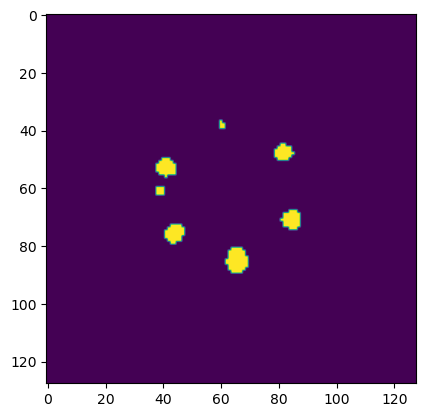

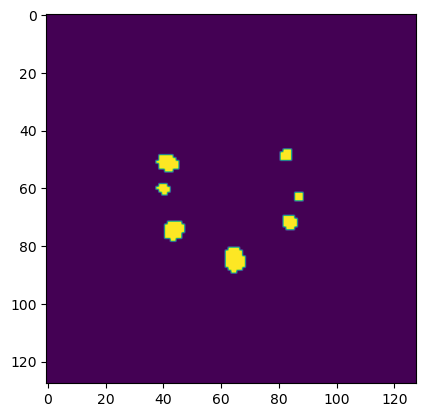

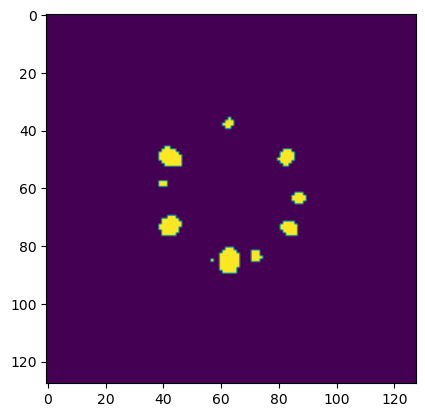

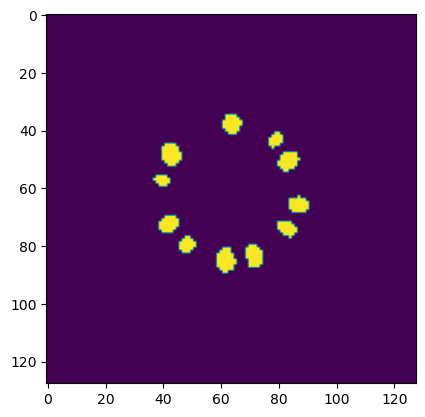

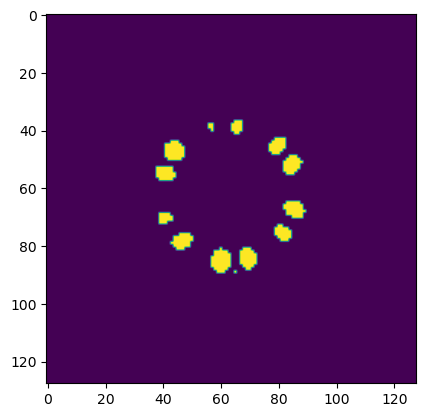

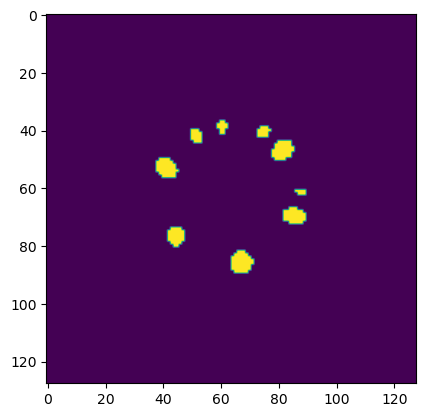

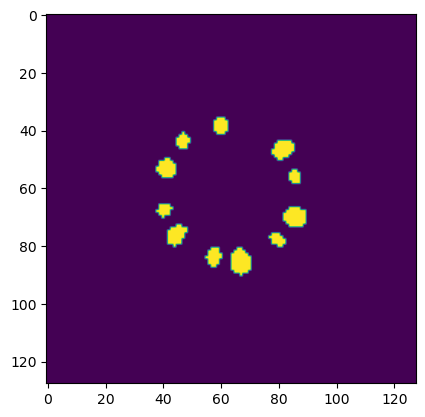

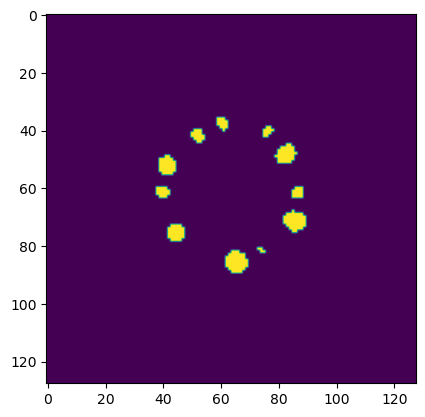

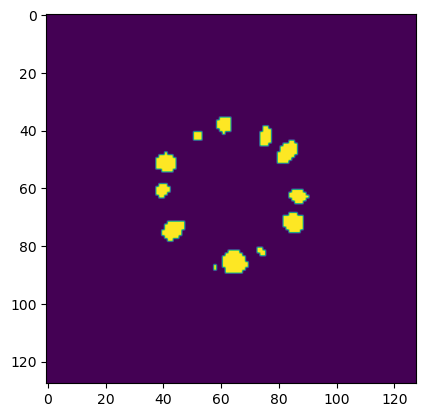

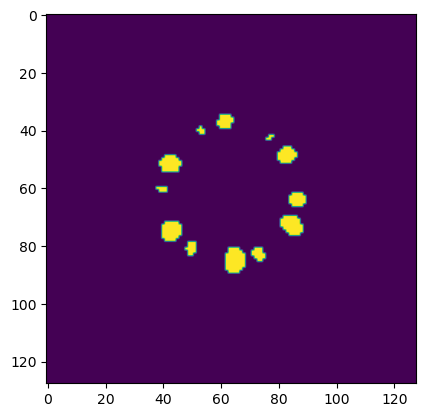

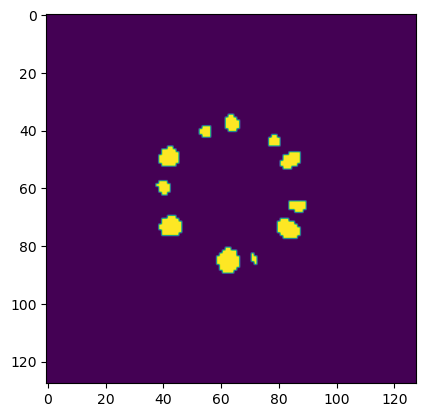

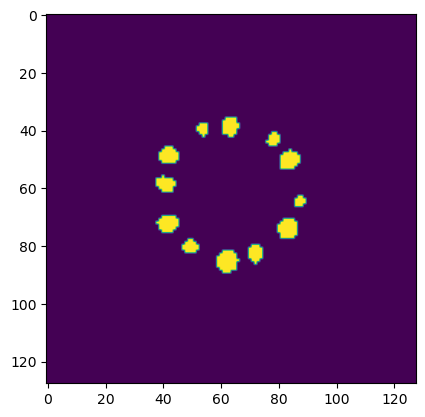

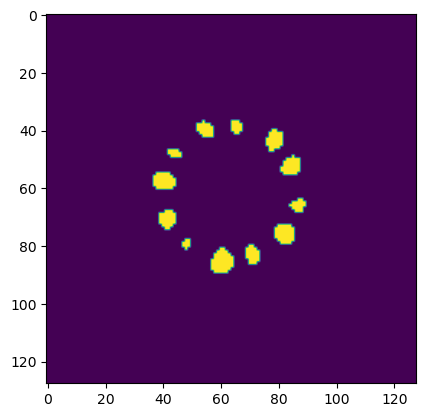

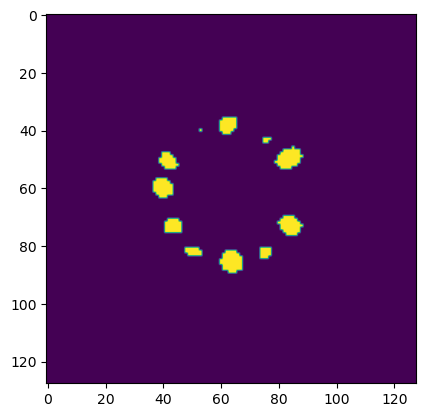

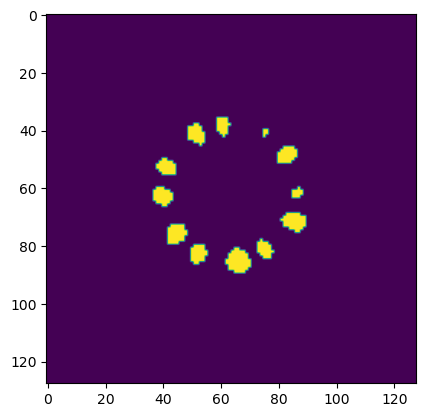

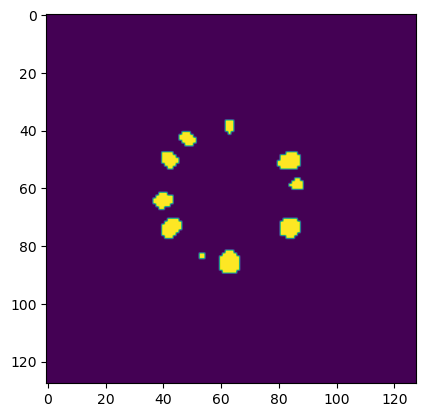

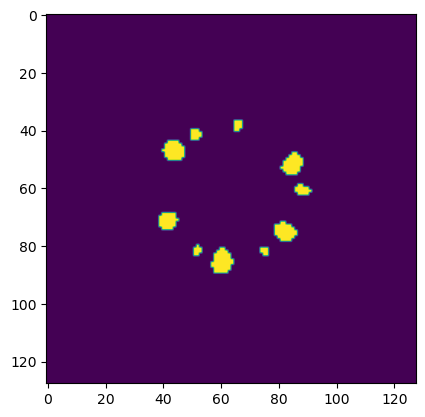

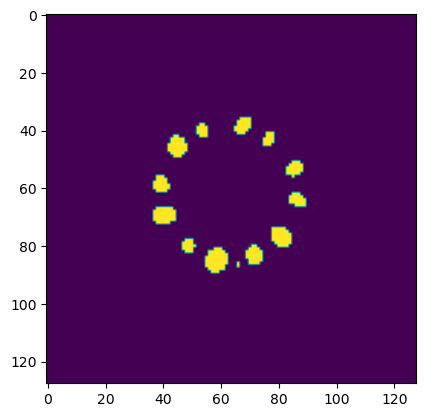

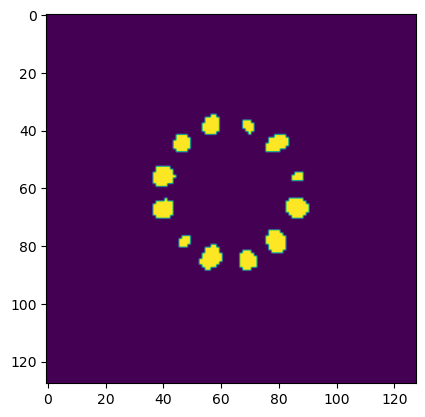

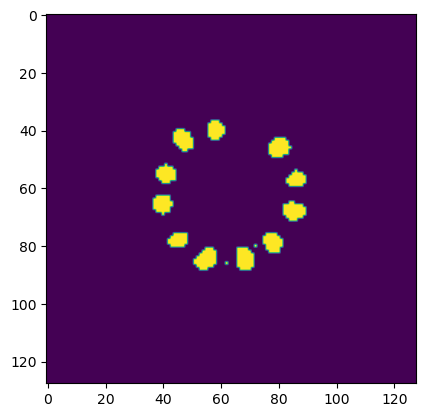

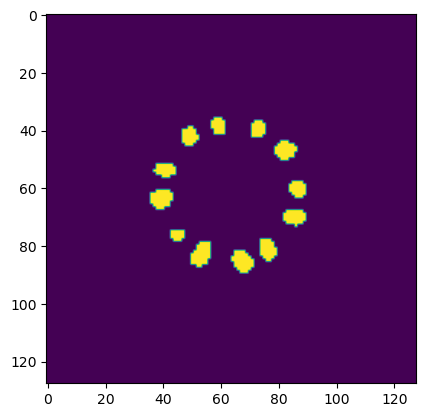

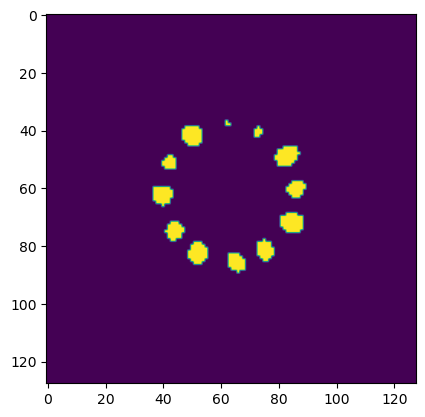

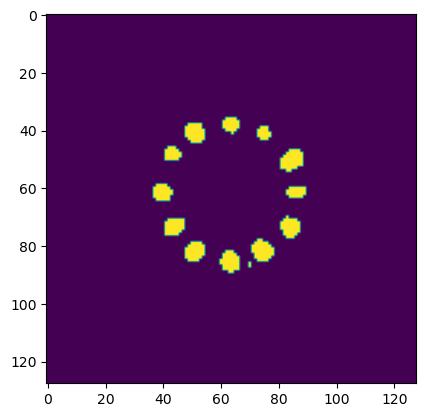

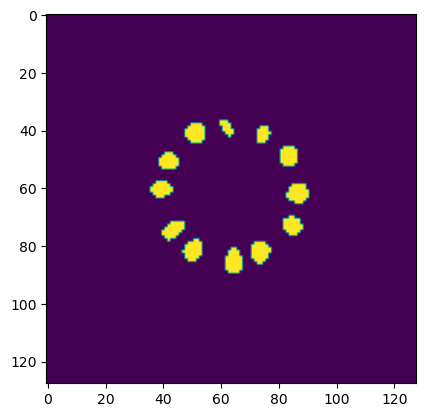

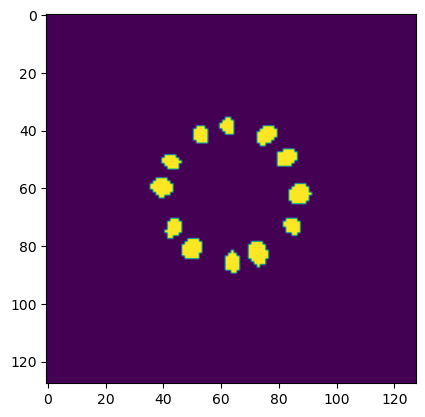

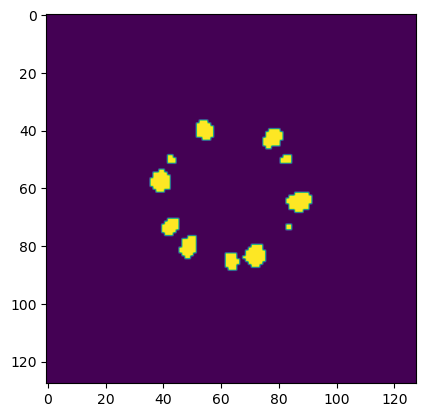

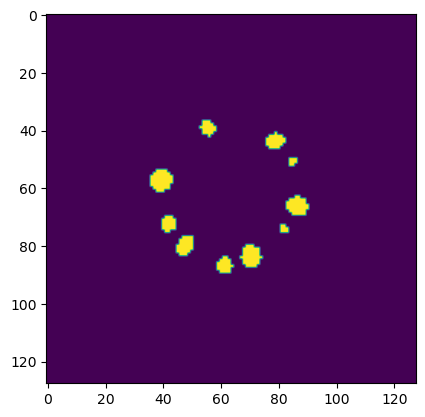

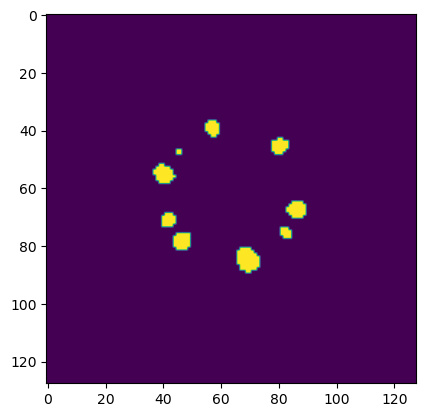

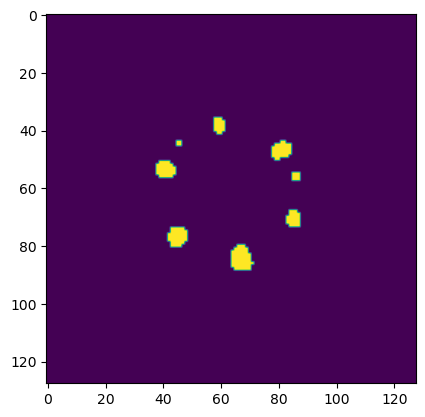

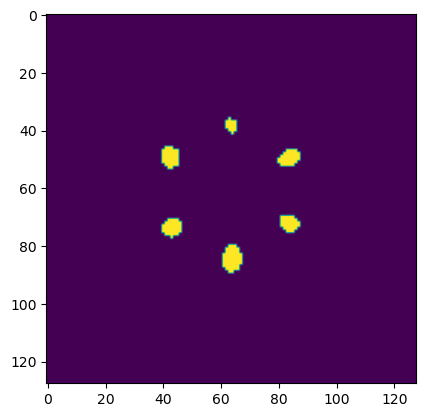

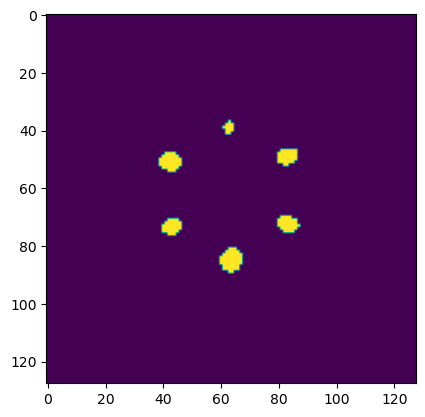

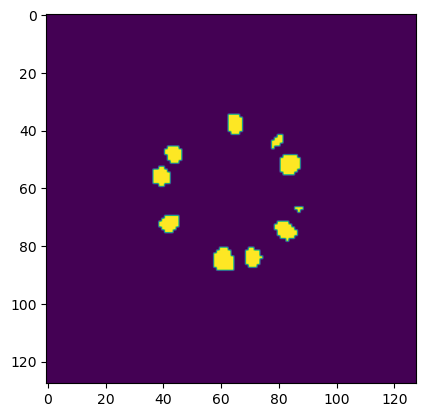

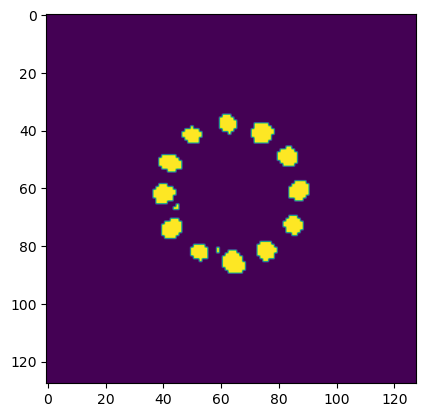

In [ ]:
for i in range(end_frame):
    offset1, filter1, offset2, filter2 = gradient_descent_optimize_offset(filtered_data[i], offset1_init, offset2_init)
    ones_filtered_data = intensity_data[i] * filter1 + intensity_data[i] * filter2
    kcluster = fourier_hexagonal_clustering(ones_filtered_data)
    plt.imshow(kcluster)
    # plt.imshow(intensity_data[i] * filter2)
    plt.show()